<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/TFM__TABULAR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def mute_print(*args, **kwargs):
    pass
normal_print = print

# IMPORTS

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.layers import Dense, Flatten, Activation, Dropout, Reshape, Conv1D, Masking, LSTM, Conv2D, Input,Multiply, Lambda
from keras.optimizers import Adam
from keras.regularizers import L2, L1L2, L1
from keras.models import Sequential, Model
#import tensorflow_ranking as tfr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, concatenate, Conv1D, Flatten
from keras.models import Model
import numpy as np
import networkx as nx
from keras.utils import plot_model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import random
import numpy as np
import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, SpatialDropout1D, BatchNormalization, Concatenate
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping
import time
from keras import backend as K
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import tensorflow as tf
from datetime import date, timedelta

# DATOS

In [ ]:
# Ruta del archivo descargado
ruta_archivo = "categorical_dataset"

# Leer el archivo Parquet en un dataframe de pandas
table = pq.read_table(ruta_archivo)
df = table.to_pandas()

NUESTRA ETIQUETA A PREDECIR ES SI EL ACTIVO SE ENCUENTRA O NO EN EL TOP 10 (
EN FUNCION DE SU RATIO DE SHARPE) DE ACTIVOS DEL INDICE.

NUESTRO OBJETIVO NO ES PUNTUAR A LOS ACTIVOS DADO QUE LUEGO REALIZAREMOS LA ASIGNACIÓN DE PESOS A TRAVÉS DE MARKOWITZ.

NUESTRO OBJETIVO ES SELECCIONAR ACTIVOS DEL TOTAL DE ACTIVOS QUE SE ENCUENTRAN EN EL INDICE.


Una vez entrenada la red, seleccionaremos los 10 activos que tengan mas probabilidad de estar entre los 10 primeros.

In [ ]:
df

ticker       date  period_mean_return  period_std_return  \
0        A3TV 2005-08-19           -0.002801           0.011520   
1        A3TV 2005-08-22           -0.002361           0.011360   
2        A3TV 2005-08-23           -0.002069           0.011383   
3        A3TV 2005-08-24           -0.002149           0.011419   
4        A3TV 2005-08-25           -0.003519           0.011605   
...       ...        ...                 ...                ...   
209358    ZEL 2004-12-23           -0.002402           0.008431   
209359    ZEL 2004-12-27           -0.002484           0.008491   
209360    ZEL 2004-12-28           -0.002563           0.008529   
209361    ZEL 2004-12-29           -0.002522           0.008500   
209362    ZEL 2004-12-30           -0.002862           0.008747   

        period_min_return  period_max_return  sharpe_ratio  sortino_ratio  \
0               -0.030143           0.016199     -3.273502      -0.957734   
1               -0.030143           0.016199     -3.294102      -0.958229   
2               -0.030143           0.016199     -3.250204      -0.957165   
3               -0.030143           0.016199     -3.241922      -0.956960   
4               -0.030143           0.014156     -3.325083      -0.958956   
...                   ...                ...           ...            ...   
209358          -0.016590           0.021979     -2.871874      -0.946093   
209359          -0.016590           0.021979     -2.940236      -0.948382   
209360          -0.016590           0.021979     -2.893856      -0.946844   
209361          -0.016590           0.021979     -2.881434      -0.946421   
209362          -0.016590           0.021979     -2.849216      -0.945301   

            beta  treynor_ratio  benchmark_distance  informatio_ratio  \
0       0.531862      -0.005267            0.011935         -0.343632   
1       0.718641      -0.003285            0.011286         -0.305949   
2       0.582280      -0.003553            0.011391         -0.252988   
3       0.669675      -0.003209            0.011217         -0.236099   
4       0.821449      -0.004284            0.011298         -0.328375   
...          ...            ...                 ...               ...   
209358  0.445910      -0.005386            0.009521         -0.499642   
209359  0.448289      -0.005541            0.009632         -0.514711   
209360  0.448801      -0.005711            0.009690         -0.519082   
209361  0.427910      -0.005893            0.009764         -0.525455   
209362  0.482172      -0.005935            0.009994         -0.566031   

        modigliani_measure  alfa_jensen  label  
0                 0.019577    -0.055674      1  
1                 0.020188    -0.061903      1  
2                 0.019526    -0.056889      1  
3                 0.019801    -0.060056      1  
4                 0.018543    -0.067348      0  
...                    ...          ...    ...  
209358            0.005598    -0.033085      0  
209359            0.006015    -0.034153      0  
209360            0.005930    -0.033730      0  
209361            0.005927    -0.033003      0  
209362            0.006312    -0.034534      0  

[209363 rows x 15 columns]

In [ ]:
df_ordenado = df.sort_values(by='date')
df_ordenado

ticker       date  period_mean_return  period_std_return  \
22640   ALB_2 1993-09-27           -0.001971           0.018035   
174049    SAN 1993-09-27            0.000388           0.011511   
13176   ACX_1 1993-09-27           -0.001724           0.011944   
37140    BBVA 1993-09-27            0.001684           0.010576   
102541    IBE 1993-09-27            0.001913           0.012509   
...       ...        ...                 ...                ...   
92921     FER 2023-08-10            0.001721           0.007593   
174048    SAB 2023-08-10            0.001373           0.014742   
99407     GRF 2023-08-10            0.004662           0.017053   
102540    IAG 2023-08-10            0.001017           0.019294   
196108    TEF 2023-08-10           -0.000492           0.018186   

        period_min_return  period_max_return  sharpe_ratio  sortino_ratio  \
22640           -0.061189           0.033582     -1.746168      -0.871552   
174049          -0.034368           0.023298     -2.530754      -0.932128   
13176           -0.029422           0.025102     -2.615899      -0.936067   
37140           -0.017796           0.023463     -2.632097      -0.936778   
102541          -0.019467           0.036917     -2.206903      -0.914364   
...                   ...                ...           ...            ...   
92921           -0.016283           0.014882     -6.932801      -0.990093   
174048          -0.023552           0.030700     -3.594265      -0.964563   
99407           -0.028127           0.040668     -2.914289      -0.947530   
102540          -0.042307           0.059551     -2.764728      -0.942328   
196108          -0.072883           0.035037     -3.016070      -0.950759   

            beta  treynor_ratio  benchmark_distance  informatio_ratio  \
22640   0.986684      -0.001998            0.013912         -0.166872   
174049  0.693401       0.000560            0.008827          0.003517   
13176   0.525264      -0.003281            0.011648         -0.178471   
37140   0.806238       0.002088            0.005516          0.243676   
102541  0.728892       0.002625            0.009711          0.159683   
...          ...            ...                 ...               ...   
92921   0.503308       0.003420            0.007636          0.231607   
174048  0.967670       0.001419            0.011979          0.115947   
99407   0.659628       0.007067            0.016725          0.287316   
102540  0.655603       0.001552            0.018388          0.056065   
196108  1.554624      -0.000316            0.012858         -0.035366   

        modigliani_measure  alfa_jensen  label  
22640             0.009292    -0.060266      1  
174049            0.000203    -0.049354      1  
13176            -0.000783    -0.046562      1  
37140            -0.000971    -0.051349      0  
102541            0.003955    -0.048863      1  
...                    ...          ...    ...  
92921            -0.006009    -0.080013      0  
174048            0.023062    -0.105618      0  
99407             0.028983    -0.085575      1  
102540            0.030286    -0.089000      1  
196108            0.028097    -0.139407      1  

[209363 rows x 15 columns]

In [ ]:
df_ordenado.date.values[0], df_ordenado.date.values[-1]

(numpy.datetime64('1993-09-27T00:00:00.000000000'),
 numpy.datetime64('2023-08-10T00:00:00.000000000'))

## Separamos train de test por fechas

In [ ]:
df_train = df[df['date'] <= '2021-01-01']
df_train.shape

(186365, 15)

In [ ]:
df_test = df[df['date'] > '2021-01-01']
df_test.shape

(22998, 15)

In [ ]:
df_y_train = df_train.iloc[:,-1]
df_x_train = df_train.iloc[:,2:-1]

df_y_test = df_test.iloc[:,-1]
df_x_test = df_test.iloc[:,2:-1]

In [ ]:
df_y_train.shape, df_x_train.shape, df_y_test.shape, df_x_test.shape

((186365,), (186365, 12), (22998,), (22998, 12))

## Escalado de datos

In [ ]:
scaler = StandardScaler()
X_train= scaler.fit_transform(df_x_train)

In [ ]:
X_test = scaler.transform(df_x_test)

## y

In [ ]:
Y_train = np.array(df_y_train)
Y_test = np.array(df_y_test)

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((186365, 12), (186365,), (22998, 12), (22998,))

# MODELO FIJO ( De referencia )

In [ ]:
input = Input(shape=(X_train.shape[1],))

layer_1 = Dense(10, activation='relu', kernel_regularizer=L2(0.1))(input)
dropout_1 = Dropout(0.5)(layer_1)
layer_2 = Dense(5, activation='relu', kernel_regularizer=L2(0.1))(dropout_1)
dropout_2 = Dropout(0.5)(layer_2)

flatten = Flatten()(dropout_2)

output = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=input, outputs=output)

model.summary()

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 10)                130       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6     

In [ ]:
earlystopping = EarlyStopping(
    #monitor='val_loss',
    monitor='val_accuracy',
    patience=20,
    #mode='min',
    #mode='max',
    restore_best_weights=True,
    verbose = 1
    )

batch_size = 280
h = model.fit(
    X_train, Y_train,
      epochs=500,
      batch_size = batch_size,
      validation_split = 0.3,
      callbacks = [earlystopping],
      shuffle=True,
      verbose=True
          )

Epoch 1/500
466/466 [==============================] - 5s 4ms/step - loss: 0.6896 - accuracy: 0.6854 - val_loss: 0.5465 - val_accuracy: 0.7765
Epoch 2/500
466/466 [==============================] - 1s 3ms/step - loss: 0.5909 - accuracy: 0.6995 - val_loss: 0.5272 - val_accuracy: 0.8084
Epoch 3/500
466/466 [==============================] - 2s 3ms/step - loss: 0.5807 - accuracy: 0.7027 - val_loss: 0.5021 - val_accuracy: 0.8230
Epoch 4/500
466/466 [==============================] - 1s 3ms/step - loss: 0.5773 - accuracy: 0.7052 - val_loss: 0.4924 - val_accuracy: 0.8357
Epoch 5/500
466/466 [==============================] - 1s 3ms/step - loss: 0.5677 - accuracy: 0.7082 - val_loss: 0.5042 - val_accuracy: 0.8121
Epoch 6/500
466/466 [==============================] - 1s 3ms/step - loss: 0.5656 - accuracy: 0.7092 - val_loss: 0.4741 - val_accuracy: 0.8136
Epoch 7/500
466/466 [==============================] - 1s 3ms/step - loss: 0.5627 - accuracy: 0.7092 - val_loss: 0.4713 - val_accuracy: 0.8125

## history

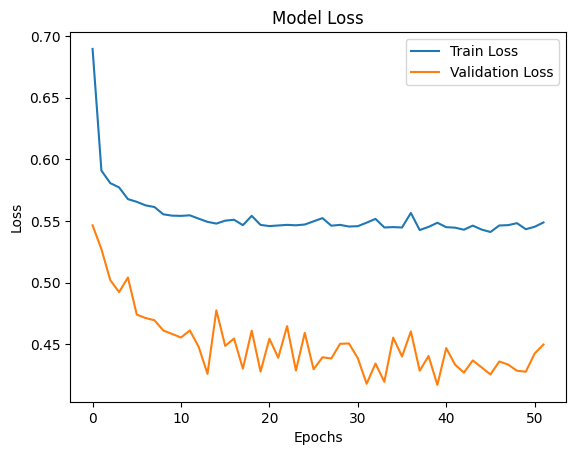

In [ ]:
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

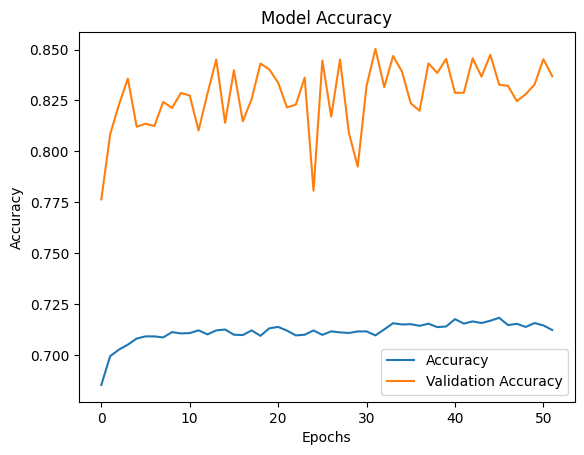

In [ ]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

## evaluate test

In [ ]:
model.evaluate(X_test, Y_test)

719/719 [==============================] - 1s 2ms/step - loss: 0.4325 - accuracy: 0.8196


[0.432483971118927, 0.8195930123329163]

# REGLAS EVOLUTIVO

##  create_model (class)

Por temas de coste computacional se reduce el numero de neuronas posibles, los resultados aumentandolas son similares, y ademas los modelos tienden a sobre aprender

In [ ]:
class create_model():

  def __init__(self):

    self.neurones_range = [1,2,3,4,5]#10]#, 15]
    self.l2_range = [0,0.3,0.6,0.9]
    self.dropout_range = [0,0.3,0.6,0.9]

    self.gen_dic = {
          "neurones_range_0":self.neurones_range,
          "neurones_range_1":self.neurones_range,
          "neurones_range_2":self.neurones_range,
          "neurones_range_3":self.neurones_range,
          "neurones_range_4":self.neurones_range,
          "neurones_range_5":self.neurones_range,

          "l2_range_0":self.l2_range,
          "l2_range_1":self.l2_range,
          "l2_range_2":self.l2_range,
          "l2_range_3":self.l2_range,
          "l2_range_4":self.l2_range,
          "l2_range_5":self.l2_range,

          "dropout_range_0":self.dropout_range,
          "dropout_range_1":self.dropout_range,
          "dropout_range_2":self.dropout_range,
          "dropout_range_3":self.dropout_range,
          "dropout_range_4":self.dropout_range,
          "dropout_range_5":self.dropout_range,

    }
  # METODOS PARA CREAR LOS INDIVIDUOS
  def crear_fila_conexiones(self, n):
    num_ones = np.random.randint(1, n + 1)
    array = np.array([1]*num_ones + [0]*(n-num_ones))
    np.random.shuffle(array)
    return array


  def crear_fila_conexiones_0(self, n):
    num_ones = np.random.randint(0, n+1)
    array = np.array([1]*num_ones + [0]*(n-num_ones))
    np.random.shuffle(array)
    return array

  def crear_individuo(self):

    neurones_range = self.neurones_range
    l2_range = self.l2_range
    dropout_range = self.dropout_range

    ind = np.concatenate((
      self.crear_fila_conexiones(5) ,
      self.crear_fila_conexiones_0(4),
      self.crear_fila_conexiones_0(3),
      self.crear_fila_conexiones_0(2),
      self.crear_fila_conexiones_0(1),

      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),
      np.random.choice(neurones_range, size=1),

      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),
      np.random.choice(l2_range, size=1),

      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),
      np.random.choice(dropout_range, size=1),


    ))

    return ind

  def crear_population(self, n):
    return np.array([self.crear_individuo() for _ in range(n)])

  def crear_matrix(self, individuo_matrix_genes):
    matrix = [
        np.concatenate((  np.array([0]) ,         individuo_matrix_genes[0:5] )),
        np.concatenate((  np.array([0,0]) ,       individuo_matrix_genes[5:9]  )),
        np.concatenate((  np.array([0,0,0]) ,     individuo_matrix_genes[9:12] )),
        np.concatenate((  np.array([0,0,0,0]) ,   individuo_matrix_genes[12:14]  )),
        np.concatenate((  np.array([0,0,0,0,0]) , individuo_matrix_genes[14:15]  )),
        np.array([0,0,0,0,0,0]),
    ]
    return matrix


  # METODOS PARA CREAR MODELO

  def output_layer(self, node_outputs, output_shape, activation='sigmoid' ):

    m = Flatten()(list(node_outputs.values())[-1])
    # Crear ultima capa densa para el modelo
    node_output = Dense(1, activation=activation, name="OUTPUT"  )(m)
    # Almacenar la salida


    return node_output

  def normal_layer(self, node, node_input, n_neurons, l2, do):
    m = Dense(n_neurons, activation='relu', kernel_regularizer=L2(l2), name="Densa_" + str(node) )(node_input)
    m = Dropout(do)(m)
    return m

  def create_model_from_graph(self, matrix, gen_neurons_array, gen_l2_array, gen_dropout_array ,input_shape, output_shape):

    graph = nx.from_numpy_array(np.array(matrix), create_using=nx.DiGraph)

    # Crear una capa de entrada para el modelo
    input_layer = Input(shape=input_shape, name="INPUT")

    # Crear un diccionario para almacenar las salidas de las capas para cada nodo
    node_outputs = {}
    disconnected_nodes = set()  # para almacenar nodos desconectados

    # CONFIGURACION RED INTERNA
    #print("----- NUEVA RED -----")
    # Procesar los nodos en orden topológico
    for node in nx.topological_sort(graph):
        node_input = None

        #print("current_nodo:" ,node )
        #print("graph.in_degree(node)", graph.in_degree(node))
        #print("predecessors:",len([predecessor for predecessor in graph.predecessors(node)]) )



        #if (graph.in_degree(node) == 0) and (node == 0) :
        if (graph.in_degree(node) == 0) and (len(node_outputs) == 0) :
            # El primer nodo tiene el input como entrada , OBLIGATORIO, es el priemro de todos y nunca tiene "padre"
            node_input = input_layer
        elif (graph.in_degree(node) == 0) and (node != 0 ):
            # Si el nodo no tiene predecesores, su entrada es la capa de entrada del modelo
            disconnected_nodes.add(node)
            #print("nodo desconectado")
            continue

        else:
            len_aux =  len([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes])
            # Todos sus predecesores estan desconectados
            if(len_aux == 0):
              disconnected_nodes.add(node)
              #print("nodo desconectado2")
              continue
            #print("len clean ", len([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes]) == 0)
            # Verificar si el nodo actual tiene algún predecesor desconectado
            #if any(predecessor in disconnected_nodes for predecessor in graph.predecessors(node)):
                #disconnected_nodes.add(node)
                #continue
            #print("desconectados:" ,disconnected_nodes )
            #print("predecessors:",[predecessor for predecessor in graph.predecessors(node)] )
            #print("LEN predecessors:",len([predecessor for predecessor in graph.predecessors(node)]))

            # Si el nodo tiene predecesores, su entrada es la concatenación de las salidas de sus predecesores
            #node_input = concatenate([node_outputs[predecessor] for predecessor in graph.predecessors(node)])
            # Si el nodo tiene predecesores, su entrada es la concatenación de las salidas de sus predecesores

            if len([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes]) > 1:
              node_input = concatenate([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes])
            else:
              #print([node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes])
              node_input = [node_outputs[predecessor] for predecessor in graph.predecessors(node) if predecessor not in disconnected_nodes][0]

        # Crear una capa densa para el nodo
        node_output = self.normal_layer(node, node_input, gen_neurons_array[node], gen_l2_array[node], gen_dropout_array[node])        # normal_layer(node, node_input, n_neurons, l2, do):

        # Almacenar la salida de la capa para este nodo
        node_outputs[node] = node_output
        #print("node_outputs ", node_outputs)

    # CONFIGURACION PARA SALIDA

    model_output = self.output_layer(node_outputs, output_shape, activation='sigmoid' )
    # Crear el modelo de Keras
    model = Model(inputs=input_layer, outputs=model_output)


    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

    return model


  def create_model(self, indv, X_shape, Y_shape):

    indv_matrix = self.crear_matrix(indv)

    indv_model = self.create_model_from_graph(indv_matrix, indv[15:21], indv[21:27], indv[27:33] , X_shape, Y_shape)

    return indv_model

##  evo_rules (class)

In [ ]:
class evo_rules():
  def __init__(self, create_model):
    self.this_ = self
    self.create_model = create_model

  def fitness_function(self,population, X_TRAIN,  Y_TRAIN, epochs, patience = 50,  verbose = 0 ):

    h_layers =      np.empty(population.shape[0])
    h_params =      np.empty(population.shape[0])
    val_loss_win =  np.empty(population.shape[0])
    val_accuracy =  np.empty(population.shape[0])

    for i in range(population.shape[0]):

          model = self.create_model(population[i],  X_TRAIN.shape[1:], 1 )

          # Define el callback EarlyStopping
          early_stopping = EarlyStopping(monitor='val_accuracy', patience = patience, verbose=verbose, restore_best_weights=True)

          history = model.fit(X_TRAIN, Y_TRAIN,
                              epochs=epochs,
                              batch_size=X_TRAIN.shape[0],
                              validation_split= 0.3,
                              shuffle = True,
                              verbose=verbose,
                              callbacks=[early_stopping])


          vlw = ( history.history['val_loss'][-1] < history.history['loss'][-1] )  * 1
          va = max(history.history['val_accuracy'])
          #print("vlw ", vlw)
          #print("va ",va)

          val_loss_win[i] = vlw
          val_accuracy[i] = va

          h_layers[i] = len(model.layers)
          h_params[i] = sum([layer.count_params() for layer in model.layers if layer.trainable])




    return val_loss_win * val_accuracy, h_layers, h_params

  def uniform_crossover(self, parents, chance_flip = 0.5):

        def uniform_crossover(parent1, parent2):
            child1, child2 = parent1.copy(), parent2.copy()
            for i in range(len(parent1)):
                if np.random.uniform(0, 1) < chance_flip:  # Choose randomly
                    child1[i], child2[i] = child2[i], child1[i]  # Swap elements
            return child1, child2

        def easy_crossover(parents):
            parents = parents
            np.random.shuffle(parents)
            offspring = []
            for i in range(0, len(parents), 2):

                parent1 = parents[i]
                parent2 = parents[i+1]

                childs = uniform_crossover(parent1, parent2 )

                offspring.append(childs[0])
                offspring.append(childs[1])

            return offspring

        return np.array(easy_crossover(parents))

  def mutation(self, immigration ,offspring, chance_flip = 0.05):

        def uniform_crossover_mut(parent1, parent2):
            child1, child2 = parent1.copy(), parent2.copy()
            for i in range(len(parent1)):
                if np.random.uniform(0, 1) < chance_flip:  # Choose randomly
                    child1[i], child2[i] = child2[i], child1[i]  # Swap elements
            return child1, child2

        def easy_crossover(immigration , current_offspring):

            new_offspring = []
            for i in range(len(immigration)):

                parent1 = immigration[i]
                parent2 = current_offspring[i]

                childs = uniform_crossover_mut(parent1, parent2 )

                #new_offspring.append(childs[0])
                new_offspring.append(childs[1])

            return new_offspring

        return np.array(easy_crossover(immigration , offspring))


  def get_best_population(self, population, fitness, n_save_best_population):
    idx_best_pop = np.argsort(fitness)[::-1][:n_save_best_population]
    return np.array(population)[idx_best_pop]



## ver_evo (class)

In [ ]:
class ver_evo():
  def __init__(self, gen_dic):

    self.gen_dic = gen_dic

    self.historical = self.historical = {key: {} for key in self.gen_dic.keys()}


  def count_occurrences(self, values, population):
      return {value: np.sum(population == value) for value in values}

  def count_gen(self, pop, generation):

    counts = {}
    keys = list(self.gen_dic.keys())

    for i in range(len(self.gen_dic)):
      #print(i)

      #print(self.gen_dic[keys[i]])

      counts[keys[i]] = self.count_occurrences(self.gen_dic[keys[i]], pop[:, i])

    for i in range(len(counts)):

      self.historical[keys[i]][generation] = counts[keys[i]]


  def show_historical(self):

    h =  {key: {} for key in self.gen_dic.keys()}

    fig, axs = plt.subplots(len(self.gen_dic), 1, figsize=(10, 20))
    _keys = list(self.historical.keys())

    for i in range(len(self.historical)):
      #print(i)

      h[_keys[i]] = pd.DataFrame(self.historical[_keys[i]]).T

    for i in range(len(self.historical)):

      for column in h[_keys[i]].columns:

        axs[i].plot(h[_keys[i]][column], label=str(column))

      axs[i].set_title(_keys[i])
      axs[i].set_ylabel('N_MODELS')
      axs[i].set_xlabel('GENERACIONES')
      axs[i].legend()

    plt.tight_layout()
    plt.show()



# EVOLUTIVO

## evo_get_model (def)

In [ ]:
def evo_get_model(
  X_train , Y_train,
  pop,
  n_generations = 3,
  #n_initial_population = 4,
  n_epochs = 2,
  n_best_pop = 2,
  n_parents = 2,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.35,
  n_immigration_population = 0,
  n_callback_patience = 15
  ):


  cm = create_model()
  evo = evo_rules(cm.create_model)

  # Inicializar el mejor fitness global y el mejor individuo global
  best_global_fitness = float('-inf')  # Se asume que buscas minimizar el fitness
  best_global_individual = None
  h_best_fitness = []

  h_pop =  ver_evo(cm.gen_dic)
  h_parents_pop =  ver_evo(cm.gen_dic)
  h_best_pop =  ver_evo(cm.gen_dic)

  h_layers = {}
  h_params = {}

  #pop = cm.crear_population(n_initial_population)
  new_pop = pop

  for i in range(n_generations):

    # Registra el tiempo inicial
    start_time = time.time()

    # STAR EVO
    pop = new_pop

    fitness,  layers, params = evo.fitness_function(pop,
                        X_train , Y_train,
                        n_epochs,
                        n_callback_patience,
                        verbose = 0 )

    h_layers[i] = layers
    h_params[i] = params

    best_pop = evo.get_best_population(pop, fitness, n_save_best_population = n_best_pop)

    parents = evo.get_best_population(pop, fitness, n_save_best_population = n_parents)

    offspring = evo.uniform_crossover(parents, chance_flip = n_chance_flip_crossover)

    gens_for_mutation = cm.crear_population(len(parents))
    mutated = evo.mutation(gens_for_mutation ,parents, chance_flip = n_chance_flip_mutation)

    immigration = cm.crear_population(n_immigration_population)

    new_pop = np.concatenate((offspring, mutated))
    new_pop = np.concatenate((new_pop, best_pop))
    if len(immigration) > 0: new_pop = np.concatenate((new_pop, immigration))


    # FIN EVO

    # Identificar el mejor fitness de la generación y el correspondiente individuo
    best_value_index = np.argmax(fitness)
    best_value = fitness[best_value_index]
    best_individual = pop[best_value_index]

    # Comparar con el mejor global
    if best_value > best_global_fitness:
        best_global_fitness = best_value
        best_global_individual = best_individual.copy()
        print("BEST")
        print(best_global_fitness)
        print(best_global_individual)


    h_pop.count_gen(              new_pop[:, -18:],  i)
    h_parents_pop.count_gen(      parents[:, -18:],  i)
    h_best_pop.count_gen(         best_pop[:, -18:],  i)



    # Obtener el valor mínimo
    best_value = np.max(fitness)
    h_best_fitness.append(best_value)

    print("GENERACION : " , i + 1)
    print("best_fitness : " , best_value)

    # Registra el tiempo final
    end_time = time.time()
    # Calcula la diferencia
    elapsed_time = end_time - start_time
    print(f"El código tomó {elapsed_time:.2f} segundos para ejecutarse.")

  # Gráfica para  h_best_fitness
  plt.plot(h_best_fitness)
  plt.title("h_best_fitness")
  plt.show()

  return best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop, h_layers, h_params

## Ejecutamos evolucion

### Una primera busqueda

In [ ]:
"""
1º n_genes * 50 / (5+n_genes) ---> 43
2º



BAJAR EPOCAS, poblacion y N_best_pop Y COSAS PARA HACERLO MAS RAPIDO
"""

BEST
0.7538365125656128
[0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  3.  2.  4.
 4.  5.  2.  0.9 0.3 0.9 0.  0.9 0.6 0.3 0.3 0.3 0.  0.9 0.3]
GENERACION :  1
best_fitness :  0.7538365125656128
El código tomó 83.00 segundos para ejecutarse.
GENERACION :  2
best_fitness :  0.7507243752479553
El código tomó 86.07 segundos para ejecutarse.
BEST
0.848774790763855
[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  4.
 4.  2.  5.  0.  0.  0.9 0.9 0.  0.3 0.6 0.  0.9 0.3 0.9 0.6]
GENERACION :  3
best_fitness :  0.848774790763855
El código tomó 96.14 segundos para ejecutarse.
BEST
0.8767662048339844
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.  2.  5.
 2.  1.  4.  0.  0.6 0.3 0.6 0.9 0.  0.  0.  0.9 0.6 0.9 0.3]
GENERACION :  4
best_fitness :  0.8767662048339844
El código tomó 101.59 segundos para ejecutarse.
GENERACION :  5
best_fitness :  0.8708459734916687
El código tomó 98.60 segundos para ejecutarse.
GENERACION :  6
best_fitness :  0.871

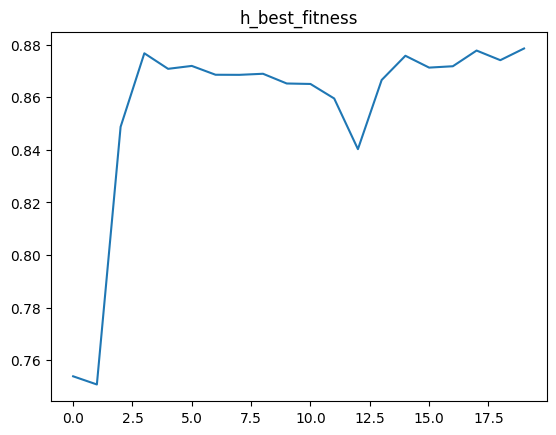

In [ ]:
best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  pop = create_model().crear_population(50),
  n_generations = 20,
  n_epochs = 250,
  n_best_pop = 10,
  n_parents = 10,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.5,
  n_immigration_population = 20,
  n_callback_patience = 10
  )

#### Guardamos pop

In [ ]:
np.save('pop_1.npy', new_pop)

files.download('pop_1.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Visualizamos evolucion de parametros y layers

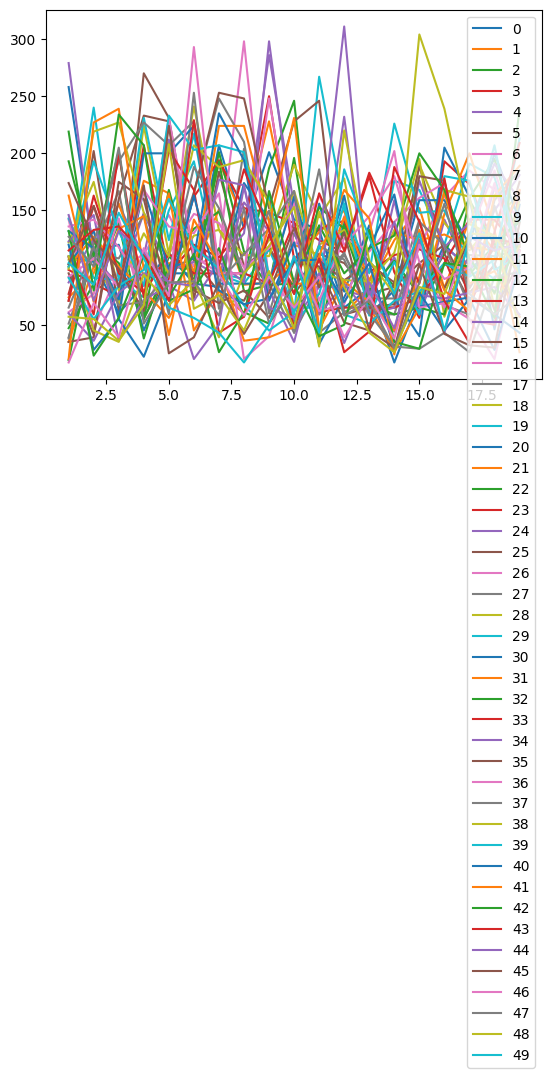

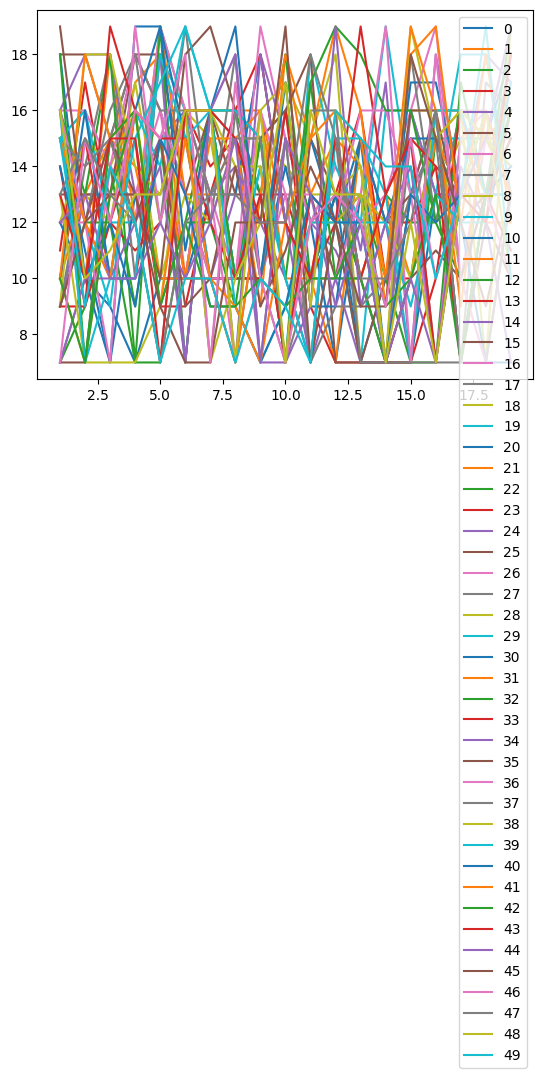

In [ ]:
del h_params[0]
pd.DataFrame(h_params).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_parametros')
plt.title('modelos_g1')
plt.legend().set_visible(False)
del h_layers[0]
pd.DataFrame(h_layers).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_layers')
plt.title('modelos_g1')
plt.legend().set_visible(False)

### Una segunda busqueda

In [ ]:
new_pop = np.load('pop_1.npy')

In [ ]:
len(new_pop)

50

BEST
0.8798604607582092
[1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  5.  2.  2.
 3.  1.  4.  0.  0.3 0.3 0.3 0.9 0.  0.  0.  0.9 0.6 0.6 0.3]
GENERACION :  1
best_fitness :  0.8798604607582092
El código tomó 285.66 segundos para ejecutarse.
BEST
0.8818458318710327
[0.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  4.  2.  4.
 4.  1.  4.  0.  0.9 0.3 0.9 0.9 0.  0.  0.6 0.  0.6 0.3 0.3]
GENERACION :  2
best_fitness :  0.8818458318710327
El código tomó 112.27 segundos para ejecutarse.
GENERACION :  3
best_fitness :  0.87869793176651
El código tomó 110.61 segundos para ejecutarse.
GENERACION :  4
best_fitness :  0.8798962831497192
El código tomó 122.86 segundos para ejecutarse.
GENERACION :  5
best_fitness :  0.8750134110450745
El código tomó 103.56 segundos para ejecutarse.
GENERACION :  6
best_fitness :  0.878662109375
El código tomó 127.56 segundos para ejecutarse.
GENERACION :  7
best_fitness :  0.8761581182479858
El código tomó 128.28 segundos para ejecutars

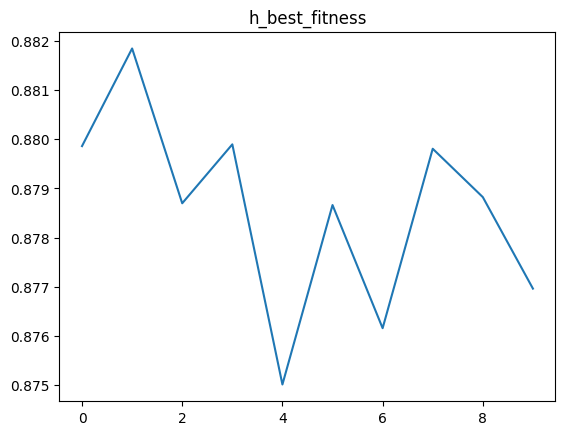

In [ ]:
best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  pop = new_pop,
  n_generations = 10,
  #n_initial_population = 18,
  n_epochs = 500,
  n_best_pop = 3,
  n_parents = 6,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.25,
  n_immigration_population = 0,
  n_callback_patience = 20
  )

### Guardamos pop

In [ ]:
np.save('pop_2.npy', new_pop)

files.download('pop_2.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Visualizamos evolucion de parametros y layers

Text(0.5, 1.0, 'modelos')

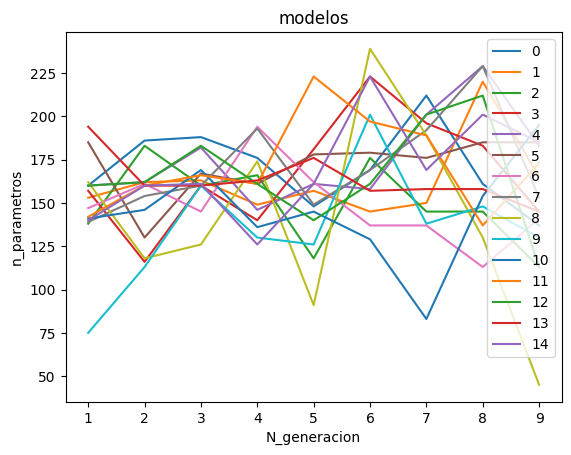

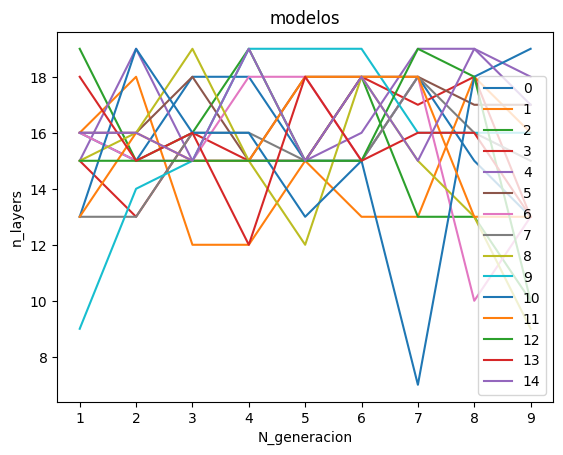

In [ ]:
del h_params[0]
pd.DataFrame(h_params).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_parametros')
plt.title('modelos_g2')
plt.legend().set_visible(False)
del h_layers[0]
pd.DataFrame(h_layers).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_layers')
plt.title('modelos_g2')
plt.legend().set_visible(False)

#### Visualizar genes por generacion

In [ ]:
h_pop.show_historical()

In [ ]:
h_parents_pop.show_historical()

In [ ]:
h_best_pop.show_historical()

### Una tercera busqueda

In [ ]:
new_pop = np.load('pop_2.npy')

In [ ]:
len(new_pop)

15

BEST
0.8805938363075256
[0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  4.  2.  4.
 3.  1.  5.  0.  0.3 0.  0.3 0.9 0.  0.  0.9 0.6 0.6 0.3 0. ]
GENERACION :  1
best_fitness :  0.8805938363075256
El código tomó 198.58 segundos para ejecutarse.
GENERACION :  2
best_fitness :  0.8803613185882568
El código tomó 98.38 segundos para ejecutarse.
GENERACION :  3
best_fitness :  0.8785905838012695
El código tomó 82.03 segundos para ejecutarse.
GENERACION :  4
best_fitness :  0.8796816468238831
El código tomó 64.40 segundos para ejecutarse.
GENERACION :  5
best_fitness :  0.8776426315307617
El código tomó 82.92 segundos para ejecutarse.
GENERACION :  6
best_fitness :  0.8767841458320618
El código tomó 74.14 segundos para ejecutarse.
BEST
0.882149875164032
[0.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  4.  2.  4.
 3.  1.  5.  0.  0.3 0.  0.3 0.9 0.  0.  0.9 0.  0.6 0.3 0. ]
GENERACION :  7
best_fitness :  0.882149875164032
El código tomó 90.11 segundos para ejecutarse.

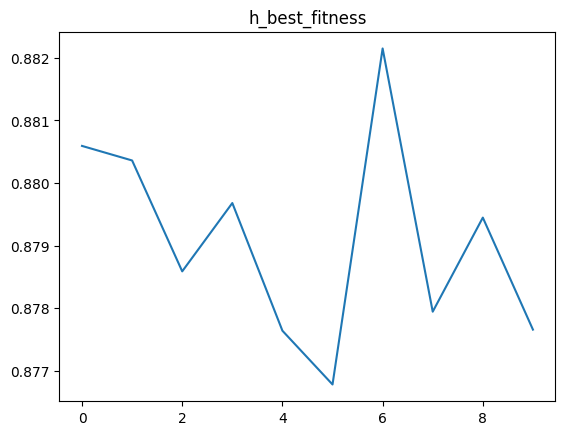

In [ ]:
best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  pop = new_pop,
  n_generations = 10,
  #n_initial_population = 18,
  n_epochs = 500,
  n_best_pop = 2,
  n_parents = 2,
  n_chance_flip_crossover = 0.25,
  n_chance_flip_mutation = 0.10,
  n_immigration_population = 0,
  n_callback_patience = 40
  )

### Guardamos pop

In [ ]:
np.save('pop_3.npy', new_pop)

files.download('pop_3.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Visualizamos evolucion de parametros y layers

Text(0.5, 1.0, 'modelos_g3')

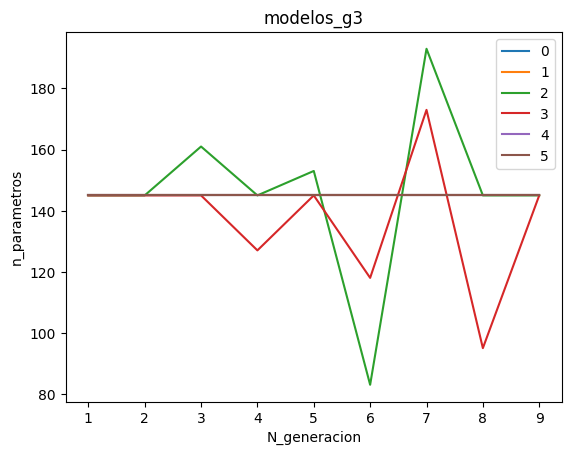

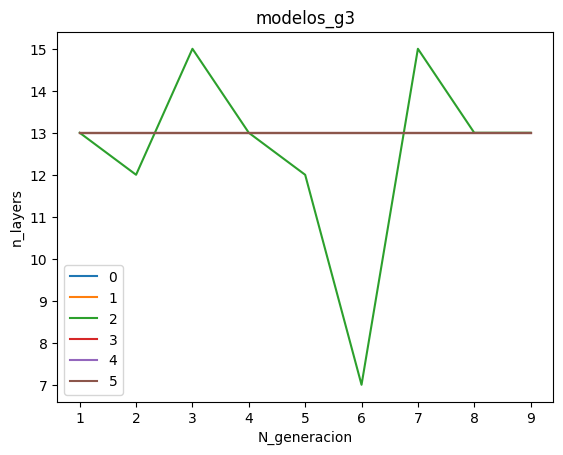

In [ ]:
del h_params[0]
pd.DataFrame(h_params).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_parametros')
plt.title('modelos_g3')
#plt.legend().set_visible(False)
del h_layers[0]
pd.DataFrame(h_layers).T.plot();
plt.xlabel('N_generacion')
plt.ylabel('n_layers')
plt.title('modelos_g3')
#plt.legend().set_visible(False)

In [ ]:
len(new_pop)

6

In [ ]:
best_global_individual, best_global_fitness

(array([0. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 0. , 1. ,
        1. , 0. , 4. , 2. , 4. , 3. , 1. , 5. , 0. , 0.3, 0. , 0.3, 0.9,
        0. , 0. , 0.9, 0. , 0.6, 0.3, 0. ]),
 0.882149875164032)

#### Visualizar genes por generacion

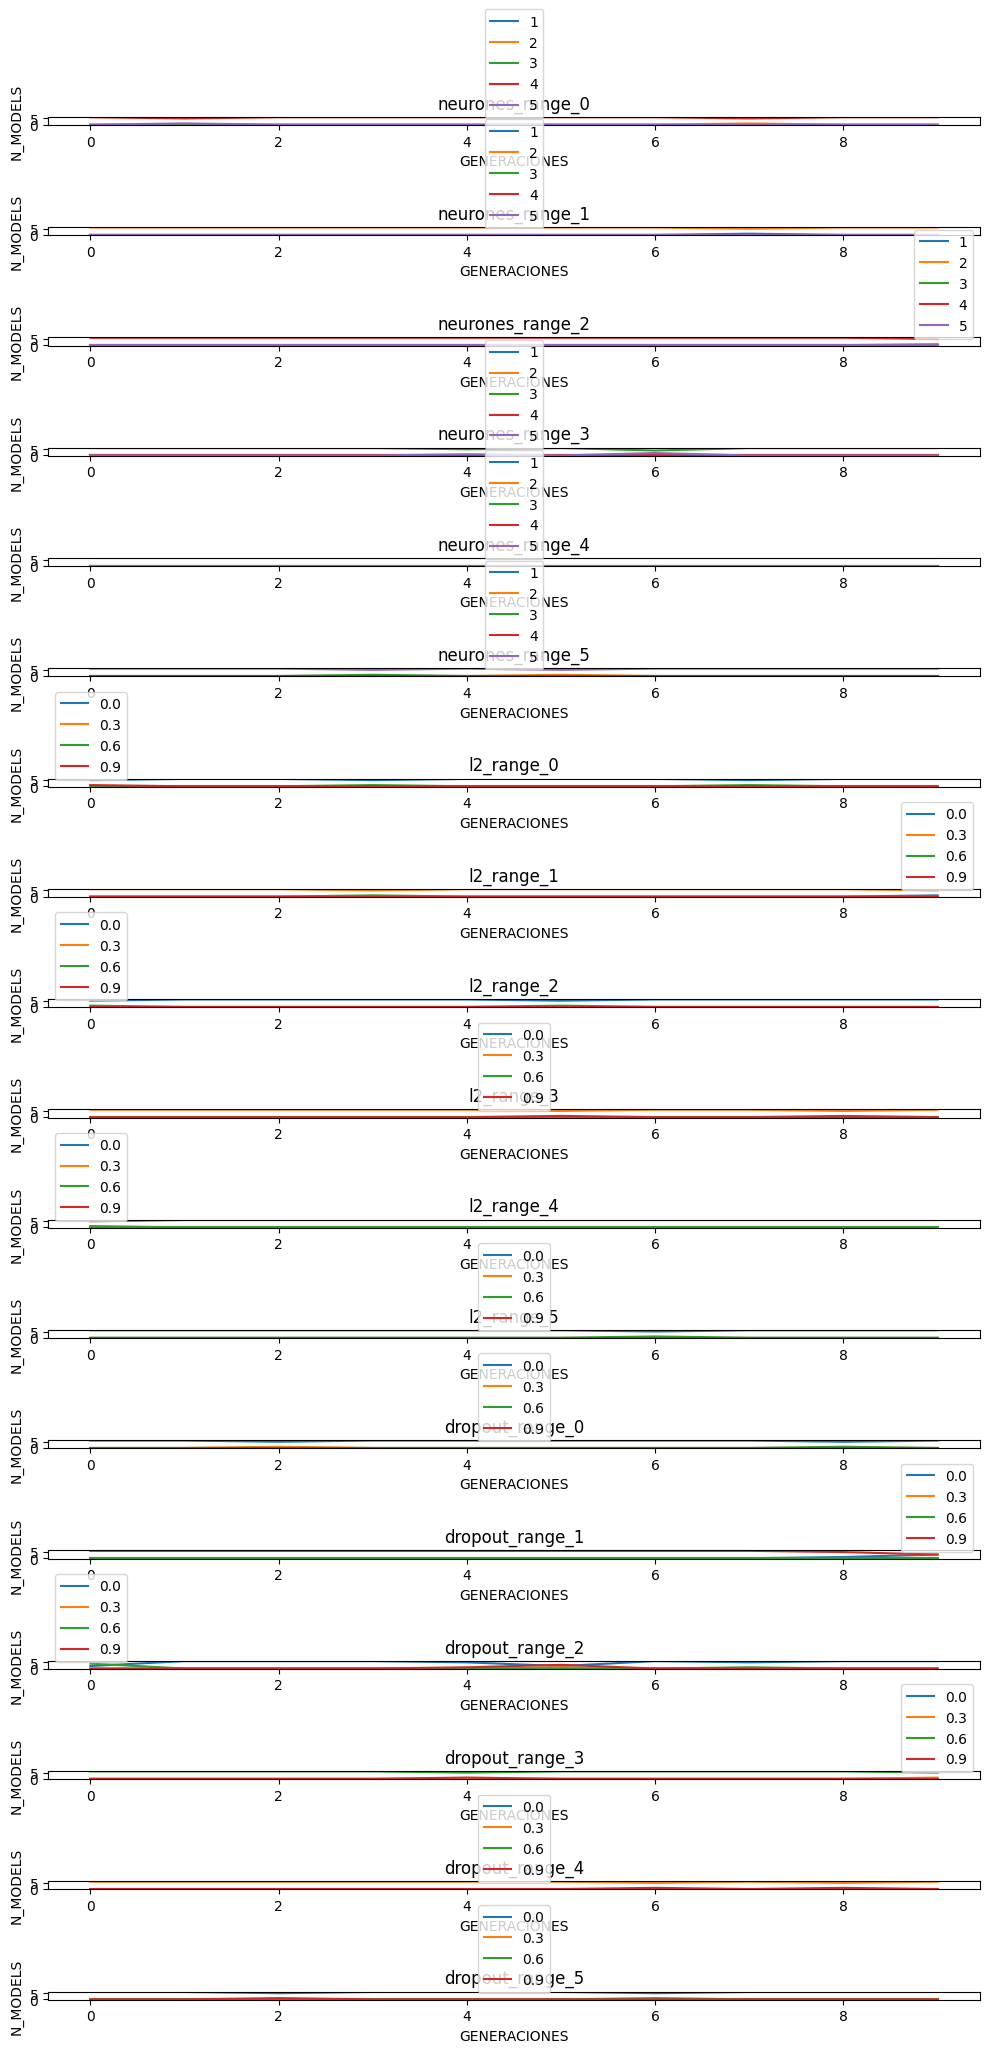

In [ ]:
h_pop.show_historical()

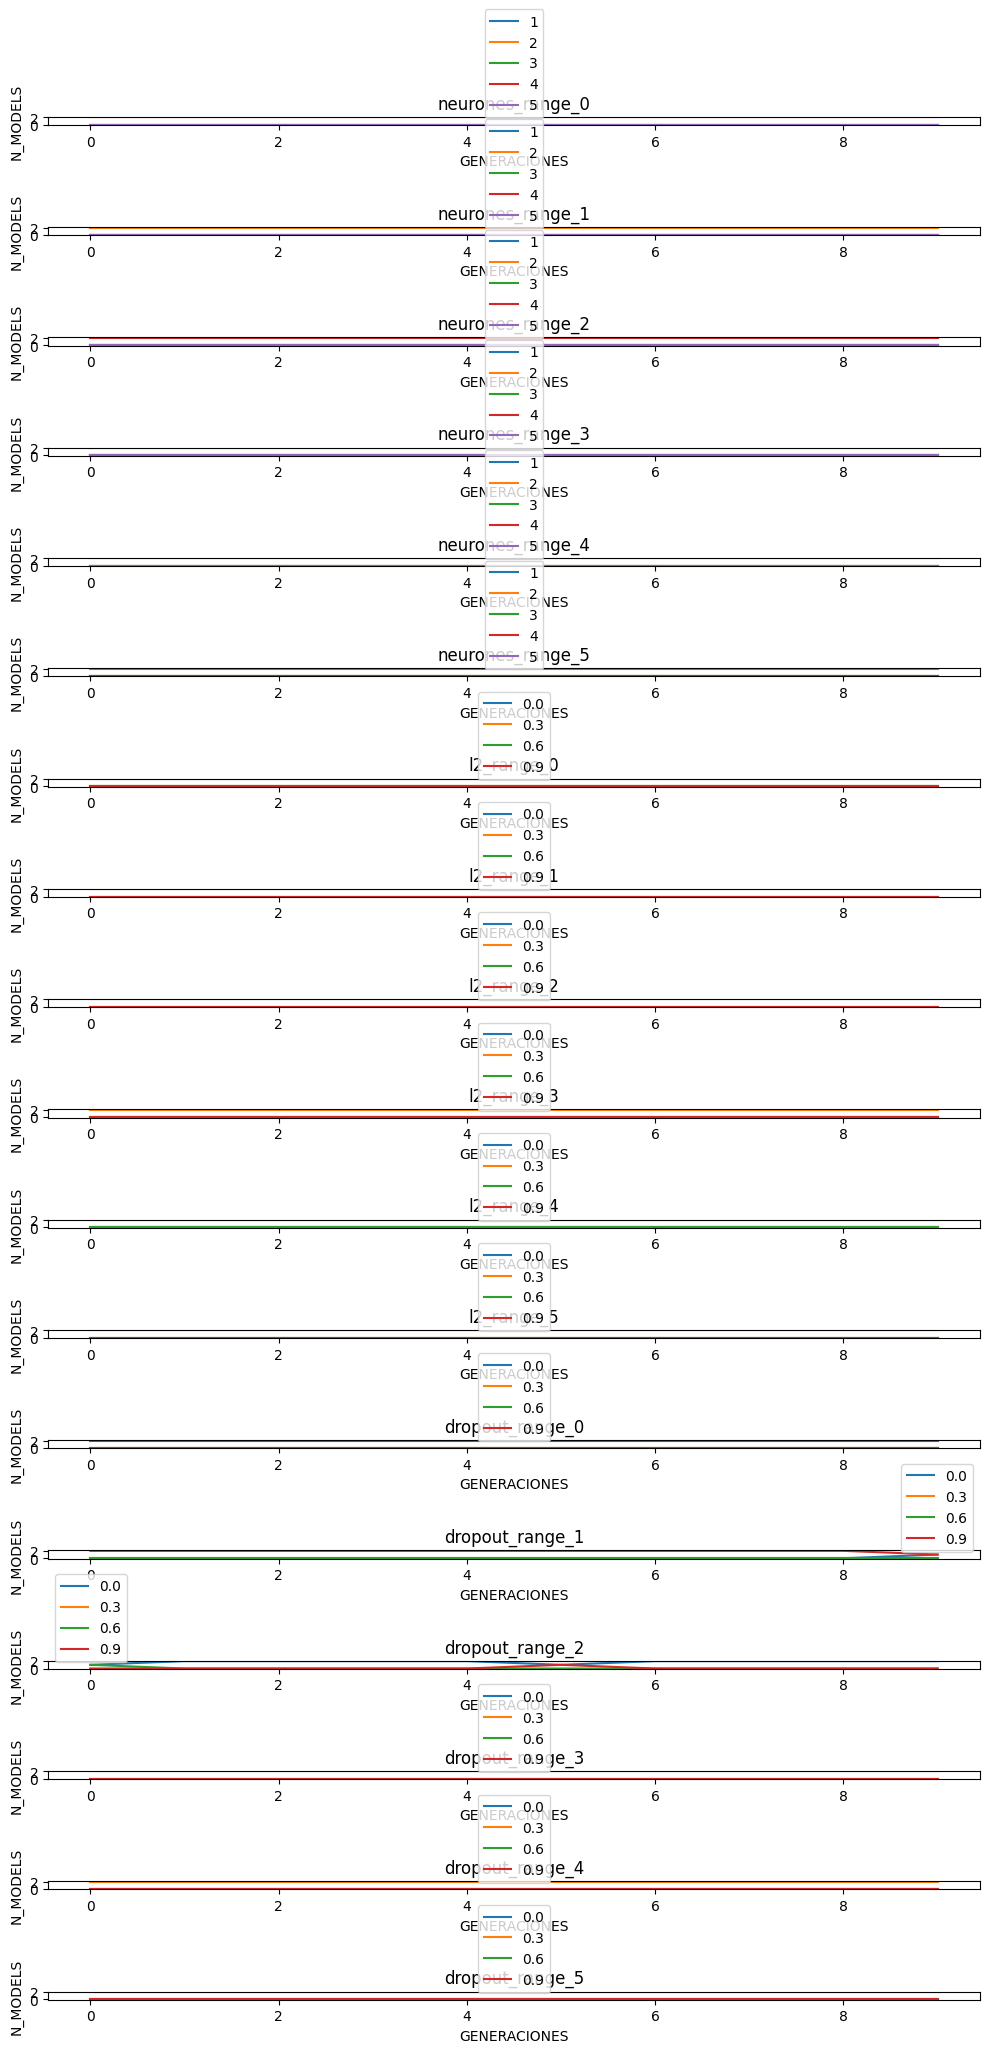

In [ ]:
h_parents_pop.show_historical()

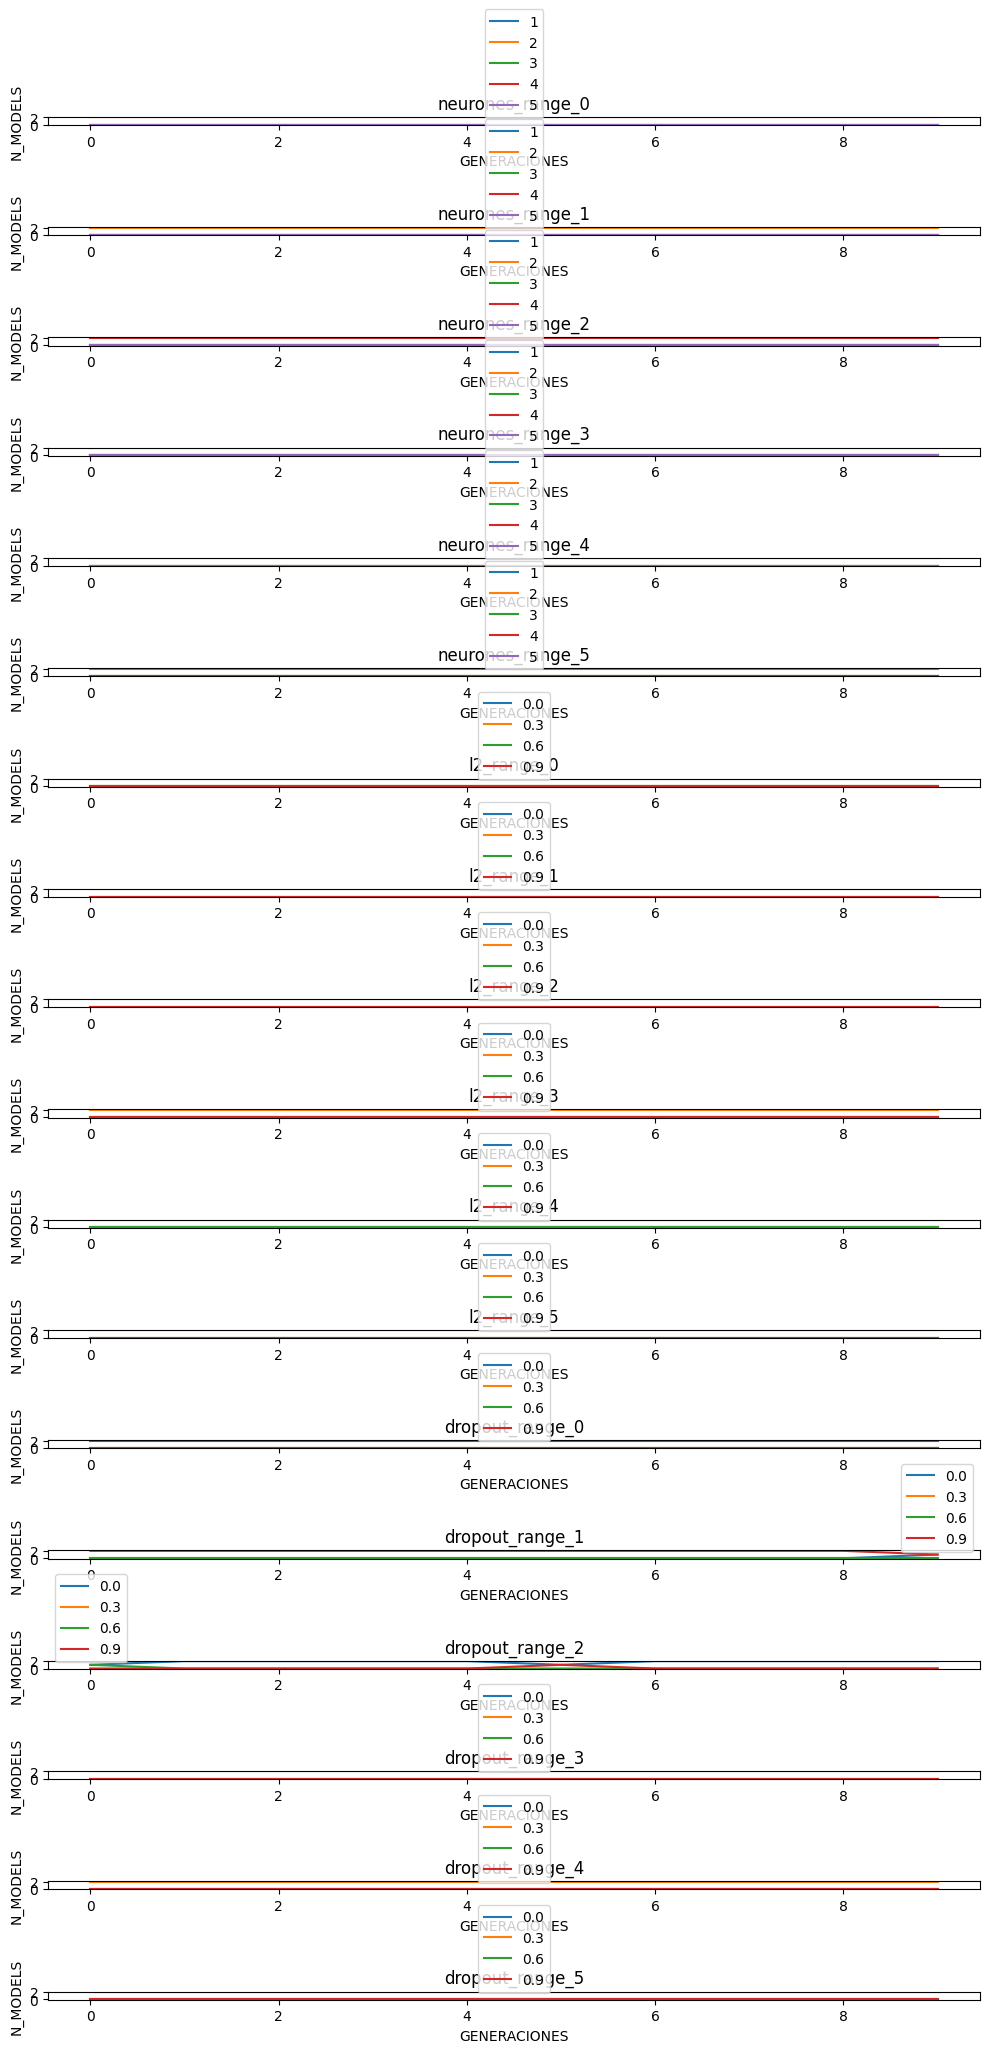

In [ ]:
h_best_pop.show_historical()

# ENTRENAMOS EL MEJOR

In [ ]:
best_global_individual, best_global_fitness

(array([0. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 0. , 1. ,
        1. , 0. , 4. , 2. , 4. , 3. , 1. , 5. , 0. , 0.3, 0. , 0.3, 0.9,
        0. , 0. , 0.9, 0. , 0.6, 0.3, 0. ]),
 0.882149875164032)

In [ ]:
best_indv = np.array([0. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 0. , 1. ,
        1. , 0. , 4. , 2. , 4. , 3. , 1. , 5. , 0. , 0.3, 0. , 0.3, 0.9,
        0. , 0. , 0.9, 0. , 0.6, 0.3, 0. ])

## Visualizar modelo

In [ ]:
_ = create_model()
model_a = _.create_model(
    best_indv,
    X_train.shape[1:],
    1)
model_a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT (InputLayer)             [(None, 12)]         0           []                               
                                                                                                  
 Densa_0 (Dense)                (None, 4)            52          ['INPUT[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 4)            0           ['Densa_0[0][0]']                
                                                                                                  
 Densa_2 (Dense)                (None, 4)            20          ['dropout[0][0]']                
                                                                                              

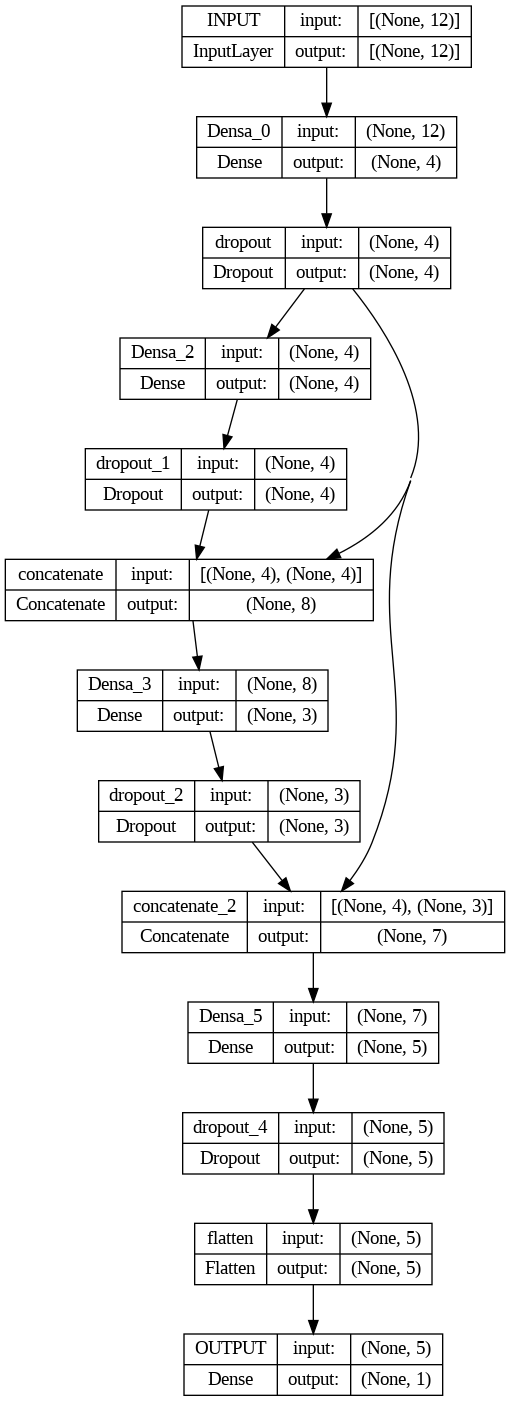

In [ ]:
#model_a.summary()
plot_model(model_a, show_shapes=True, show_layer_names=True)

In [ ]:
X_train.shape

(186365, 12)

## Entrenar modelo

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 50, verbose=1, restore_best_weights=True)

history_model_a = model_a.fit(
                              X_train,
                              Y_train,
                              epochs=1000,
                              batch_size= X_train.shape[0],
                              validation_split = 0.3,
                              verbose=1,
                              shuffle = True,
                              callbacks=[early_stopping]
                              )

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 2.2505 - accuracy: 0.5539 - val_loss: 2.1095 - val_accuracy: 0.6075
Epoch 2/1000
1/1 [==============================] - 0s 112ms/step - loss: 2.1561 - accuracy: 0.5790 - val_loss: 2.0318 - val_accuracy: 0.6387
Epoch 3/1000
1/1 [==============================] - 0s 114ms/step - loss: 2.0679 - accuracy: 0.6080 - val_loss: 1.9591 - val_accuracy: 0.6647
Epoch 4/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.9888 - accuracy: 0.6374 - val_loss: 1.8909 - val_accuracy: 0.6906
Epoch 5/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.9132 - accuracy: 0.6680 - val_loss: 1.8266 - val_accuracy: 0.7160
Epoch 6/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.8448 - accuracy: 0.6958 - val_loss: 1.7656 - val_accuracy: 0.7375
Epoch 7/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.7806 - accuracy: 0.7217 - val_loss: 1.7072 - val_accuracy: 0.7563
Epoch 8/1

## Visualizar loss y val_loss

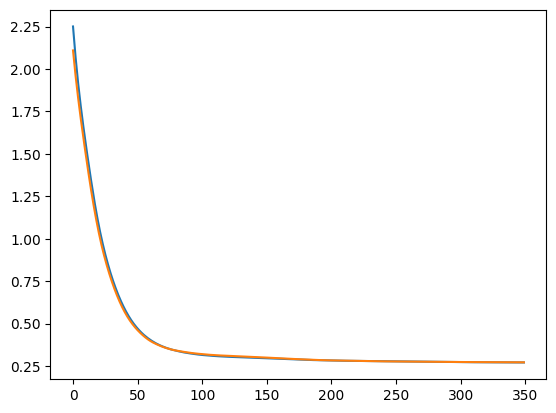

In [ ]:
plt.plot(history_model_a.history["loss"])
plt.plot(history_model_a.history["val_loss"])

## Visualizar accuracy y val_accuracy

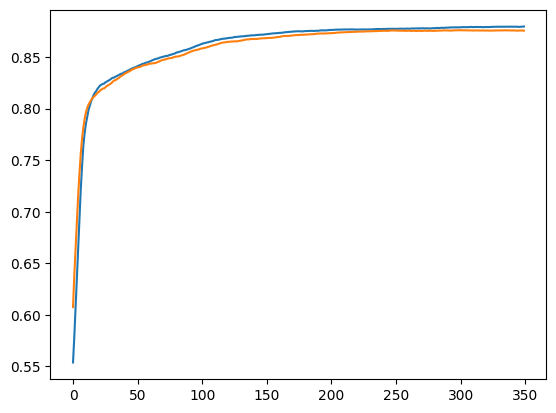

In [ ]:
plt.plot(history_model_a.history["accuracy"])
plt.plot(history_model_a.history["val_accuracy"])

# Guardamos el modelo completo en un archivo HDF5

In [ ]:
model_a.save('best_model_0.h5')

# Vemos predicciones del mejor

In [ ]:
model_a = load_model('best_model_0.h5')

In [ ]:
y_pred = model_a(X_test)

In [ ]:
y_pred.shape

TensorShape([22998, 1])

## Historico prediccion real

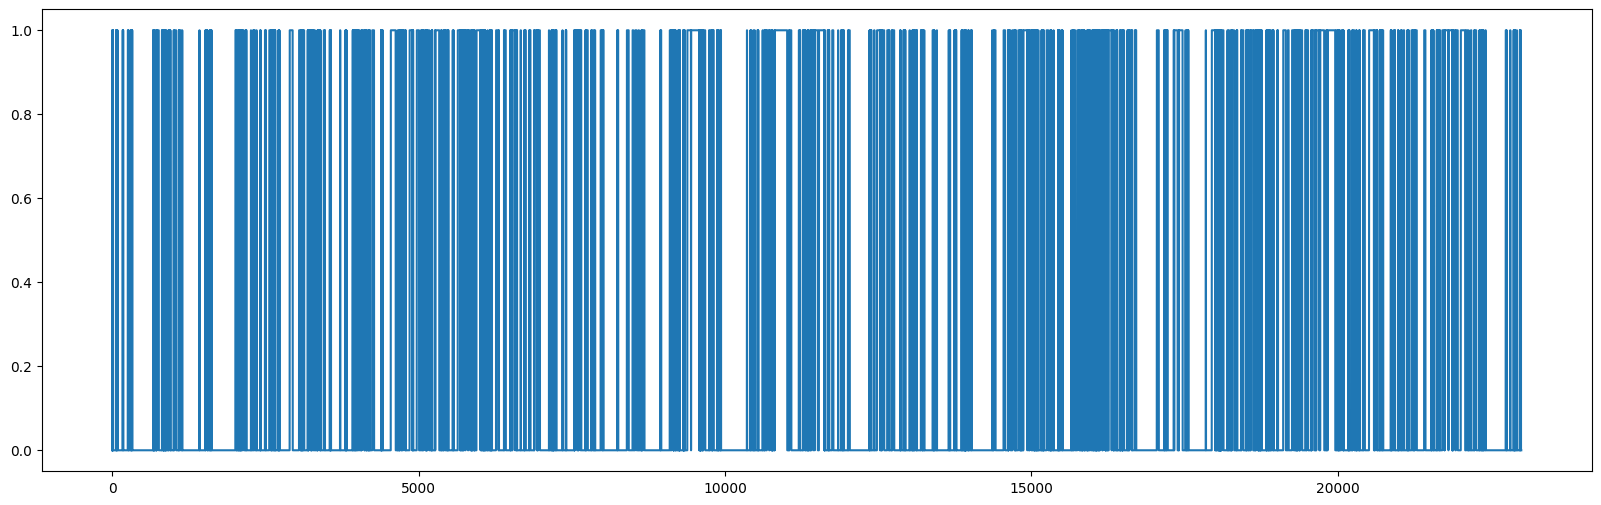

In [ ]:
plt.figure(figsize=(20, 6))
#plt.plot(pd.DataFrame(Y_test , columns=data_componentes_IBEX.columns) );
plt.plot(pd.DataFrame(Y_test));

## Historico estimacion

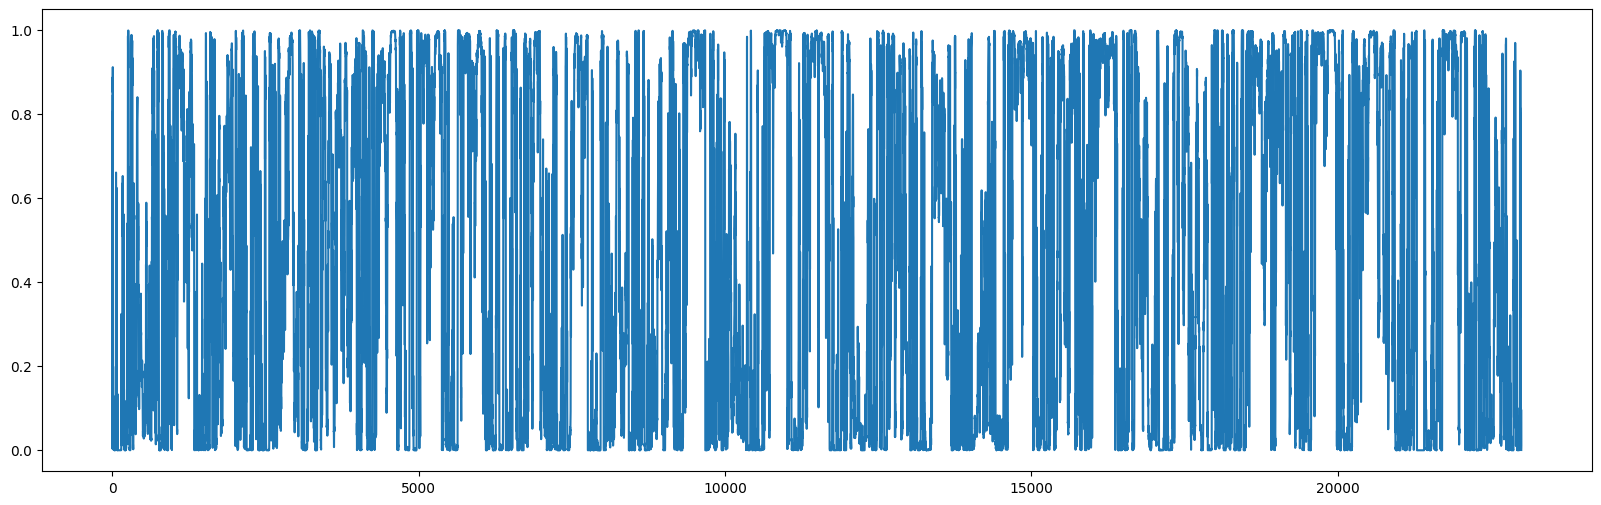

In [ ]:
plt.figure(figsize=(20, 6))
#plt.plot((pd.DataFrame(y_pred , columns=data_componentes_IBEX.columns) ));
plt.plot(pd.DataFrame(y_pred ));

# ANALISIS ACCURACY EN TEST  ( BATCHES DE 35 para cada dia )

In [ ]:
df_test.head()

ticker       date  period_mean_return  period_std_return  \
12507    ACS 2021-01-04            0.001878           0.019079   
12508    ACS 2021-01-05            0.002509           0.019232   
12509    ACS 2021-01-06            0.002084           0.018636   
12510    ACS 2021-01-07           -0.000012           0.016237   
12511    ACS 2021-01-08           -0.000084           0.016221   

       period_min_return  period_max_return  sharpe_ratio  sortino_ratio  \
12507          -0.029343           0.051768      0.054429       0.096996   
12508          -0.029343           0.051768      0.084160       0.151020   
12509          -0.029343           0.051768      0.065679       0.114409   
12510          -0.029343           0.032875     -0.053704      -0.079857   
12511          -0.029343           0.032875     -0.058185      -0.086431   

           beta  treynor_ratio  benchmark_distance  informatio_ratio  \
12507  0.940494       0.001997            0.015735          0.073656   
12508  0.949047       0.002643            0.015963          0.126516   
12509  0.888067       0.002347            0.014820          0.038311   
12510  0.723101      -0.000017            0.013931         -0.070089   
12511  0.722240      -0.000116            0.013926         -0.075156   

       modigliani_measure  alfa_jensen  label  
12507            0.001446     0.000909      0  
12508            0.001824     0.001221      1  
12509            0.001678     0.001799      0  
12510            0.000217    -0.000786      0  
12511            0.000164    -0.000859      0

Numero de dias:

In [ ]:
len(set(df_test.date))

669

## Nº activos por dia:

In [ ]:
n_activos = []

for day in set(df_test.date):
  #print(day.date())
  datos_dia = df_test[df_test.date == str(day.date())]
  #print(datos_dia.shape )

  n_activos.append(datos_dia.shape[0])



(array([ 25.,   0.,   0., 103.,   0.,   0., 136.,   0.,   0., 405.]),
 array([32. , 32.3, 32.6, 32.9, 33.2, 33.5, 33.8, 34.1, 34.4, 34.7, 35. ]),
 <BarContainer object of 10 artists>)

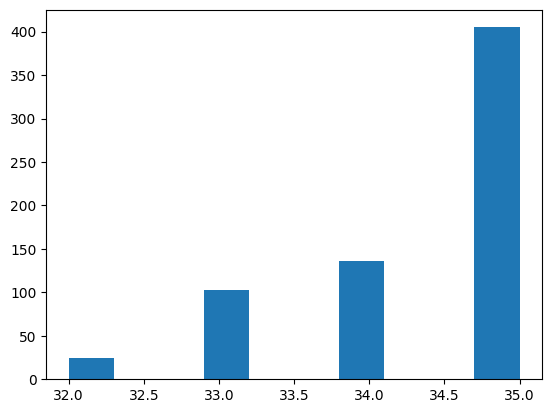

In [ ]:
plt.hist(n_activos)

## run_test (def)

In [ ]:
def run_test():
  model_fijo = load_model('best_model_0.h5')
  #model_evo = load_model('best_model_0.h5')

  h_acurracy = []
  h_FP = []
  h_FN = []

  for day in set(df_test.date):

    datos_dia = df_test[df_test.date == str(day.date())]

    y_true = np.array( datos_dia.iloc[:,-1] )
    x = datos_dia.iloc[:,2:-1]
    x = scaler.transform(x)

    y_pred = model_fijo(x)
    y_pred = y_pred.numpy().round(2).reshape(-1)

    y_pred_labels = (y_pred >= 0.5).astype(int)

    accuracy = np.mean(y_true == y_pred_labels)
    FP = np.sum((y_pred_labels == 1) & (y_true == 0))
    FN = np.sum((y_pred_labels == 0) & (y_true == 1))

    h_acurracy.append(accuracy)
    h_FP.append(FP)
    h_FN.append(FN)

  return h_acurracy, h_FP, h_FN




In [ ]:
h_acurracy, h_FP, h_FN = run_test()

## Ver Acurracy

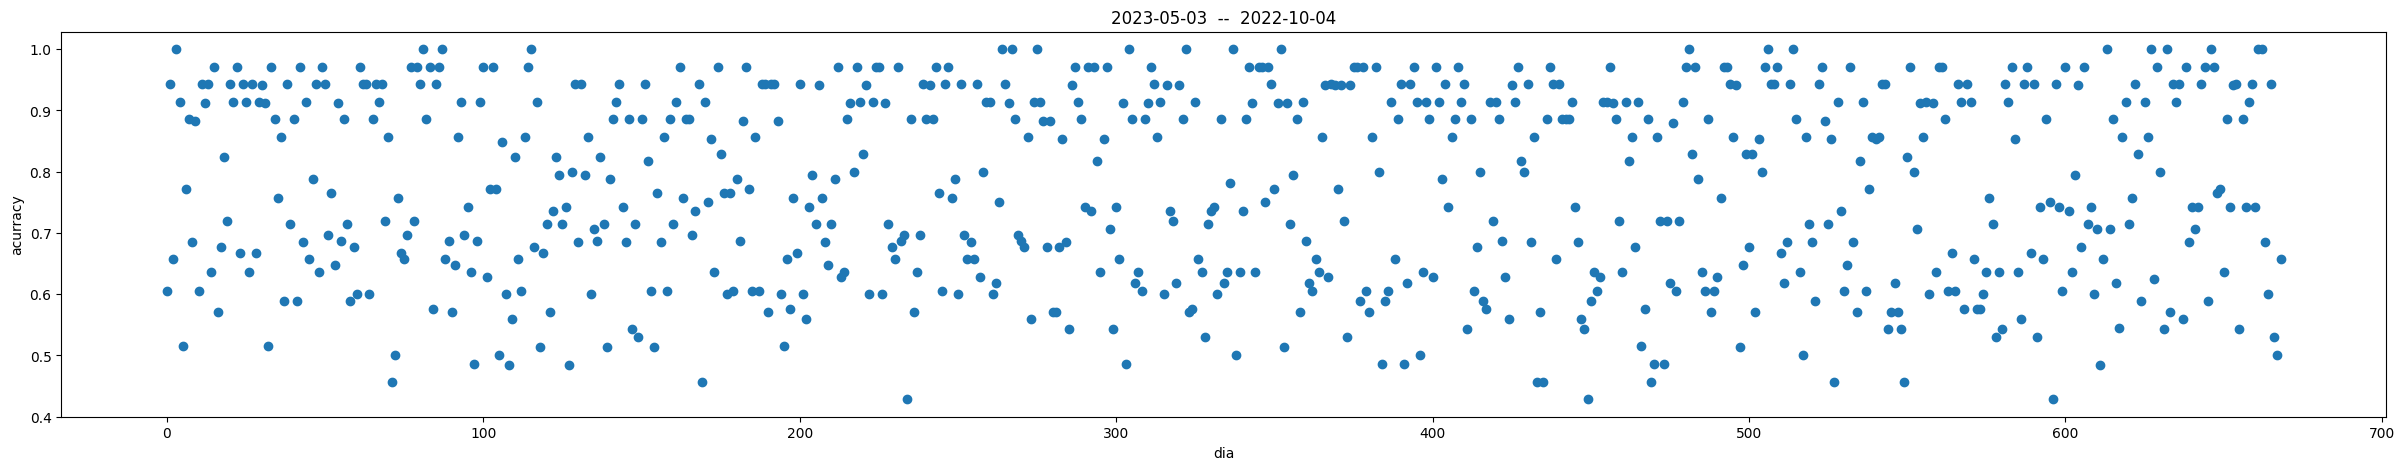

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot(h_acurracy, marker='o', linestyle='none')

ax.set_title(str(list(set(df_test.date))[0].date()) + " " + " -- " + " " + str(list(set(df_test.date))[-1].date()) )
ax.set_xlabel("dia")
ax.set_ylabel("acurracy")

plt.show()

## Ver media acumulada (def)

In [ ]:

## Ver media acumulada
def ver_media_acumulada(valores):
  # Tu array de valores
  data = np.array(valores)

  # Calcula la suma acumulativa
  cumulative_sum = np.cumsum(data)

  # Calcula la media acumulativa
  cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)

  plt.plot(cumulative_average);

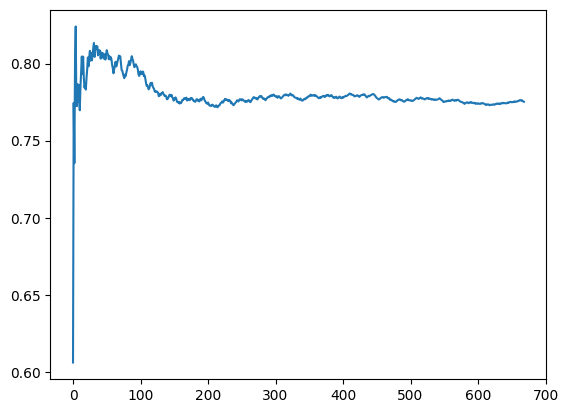

In [ ]:
## Ver media acumulada
ver_media_acumulada(h_acurracy)

## Ver Falsos Positivos

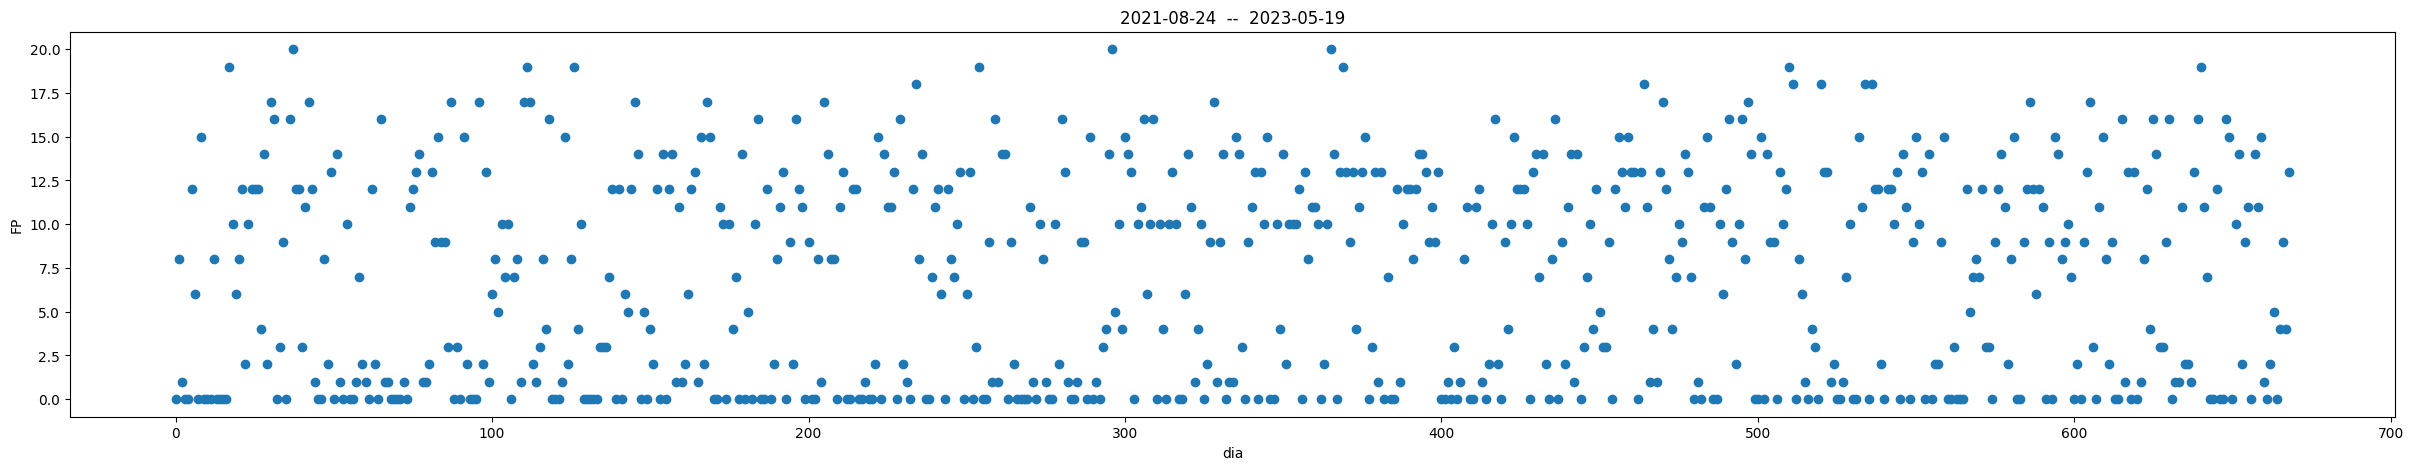

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot(h_FP, marker='o', linestyle='none')

ax.set_title(str(list(set(df_test.date))[0].date()) + " " + " -- " + " " + str(list(set(df_test.date))[-1].date()) )
ax.set_xlabel("dia")
ax.set_ylabel("FP")

plt.show()

## Ver Falsos negativos

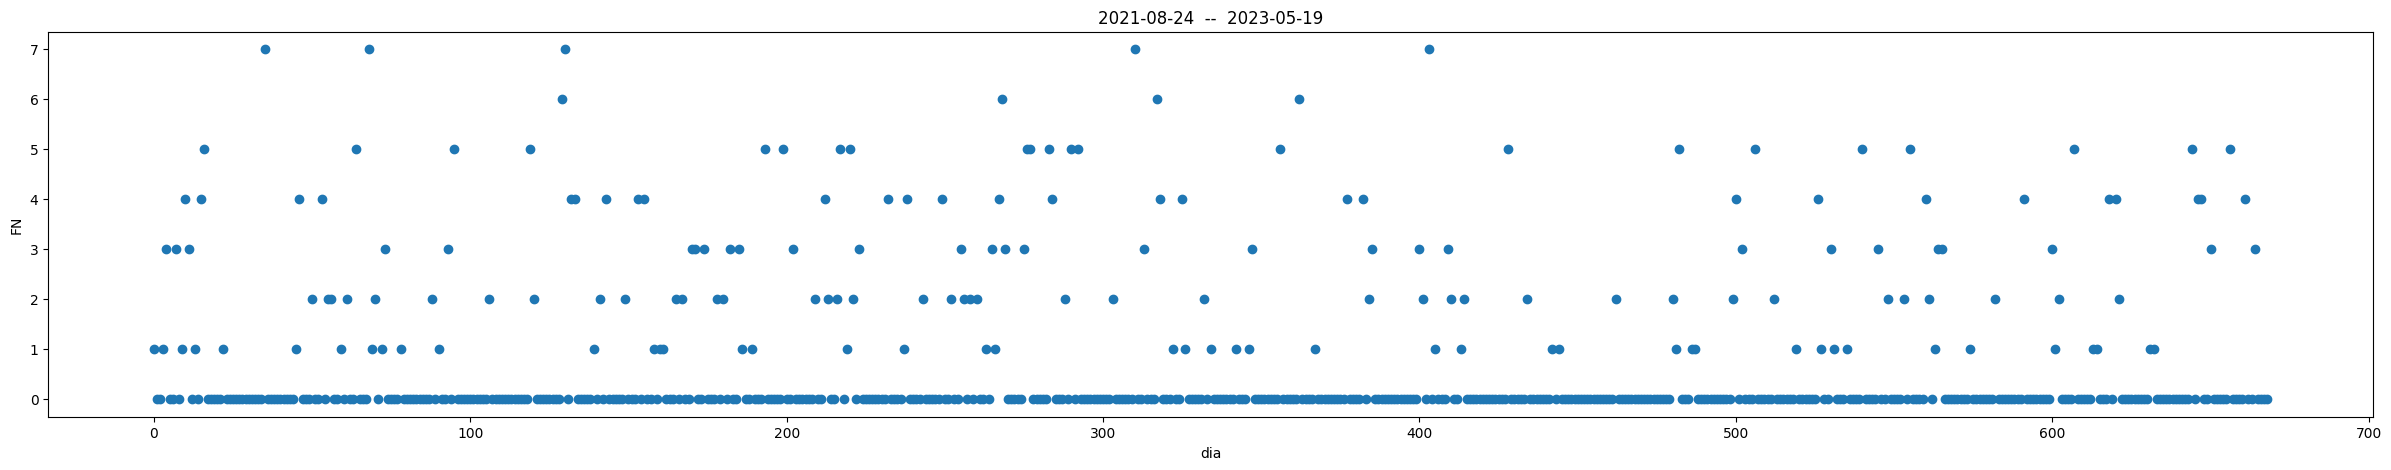

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot(h_FN, marker='o', linestyle='none')

ax.set_title(str(list(set(df_test.date))[0].date()) + " " + " -- " + " " + str(list(set(df_test.date))[-1].date()) )
ax.set_xlabel("dia")
ax.set_ylabel("FN")

plt.show()

# ANALISIS ACCURACY EN TEST  ( BATCHES DE 35 para cada dia ) CON DATOS MANIPULADOS

## run_test_manipulados (def)





In [ ]:
def run_test_manipulados(mascara):

  model_fijo = load_model('best_model_0.h5')
  h_accuracy = []
  h_acurracy_manipulado = []

  for day in set(df_test.date):

    datos_dia = df_test[df_test.date == str(day.date())]

    y_true = np.array( datos_dia.iloc[:,-1] )
    x = datos_dia.iloc[:,2:-1]
    x = scaler.transform(x)
    """
    y_pred = model_fijo(x)
    y_pred = y_pred.numpy().round(2).reshape(-1)

    y_pred_labels = (y_pred >= 0.5).astype(int)

    accuracy = np.mean(y_true == y_pred_labels)
    h_accuracy.append(accuracy)
    """
    # Datos manipulados
    x_manipulados = x * mascara(x.shape[0])

    y_pred = model_fijo(x_manipulados)
    y_pred = y_pred.numpy().round(2).reshape(-1)
    y_pred_labels = (y_pred >= 0.5).astype(int)

    accuracy = np.mean(y_true == y_pred_labels)
    h_acurracy_manipulado.append(accuracy)

  return h_accuracy, h_acurracy_manipulado

## Manipulacion 1

### mascara_1 (def)

In [ ]:
def mascara_1(n_activos, array = [1,0,0,0,0,0,0,0,0,0,0,0] ):

  mask = np.array(array)
  # Extender la máscara para que tenga la misma forma que data
  full_mask = np.tile(mask, (n_activos, 1))

  return full_mask

In [ ]:
mascara_1(4)

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])

In [ ]:
_, h_acurracy_manipulado_1 = run_test_manipulados(mascara_1)

### Ver resultados

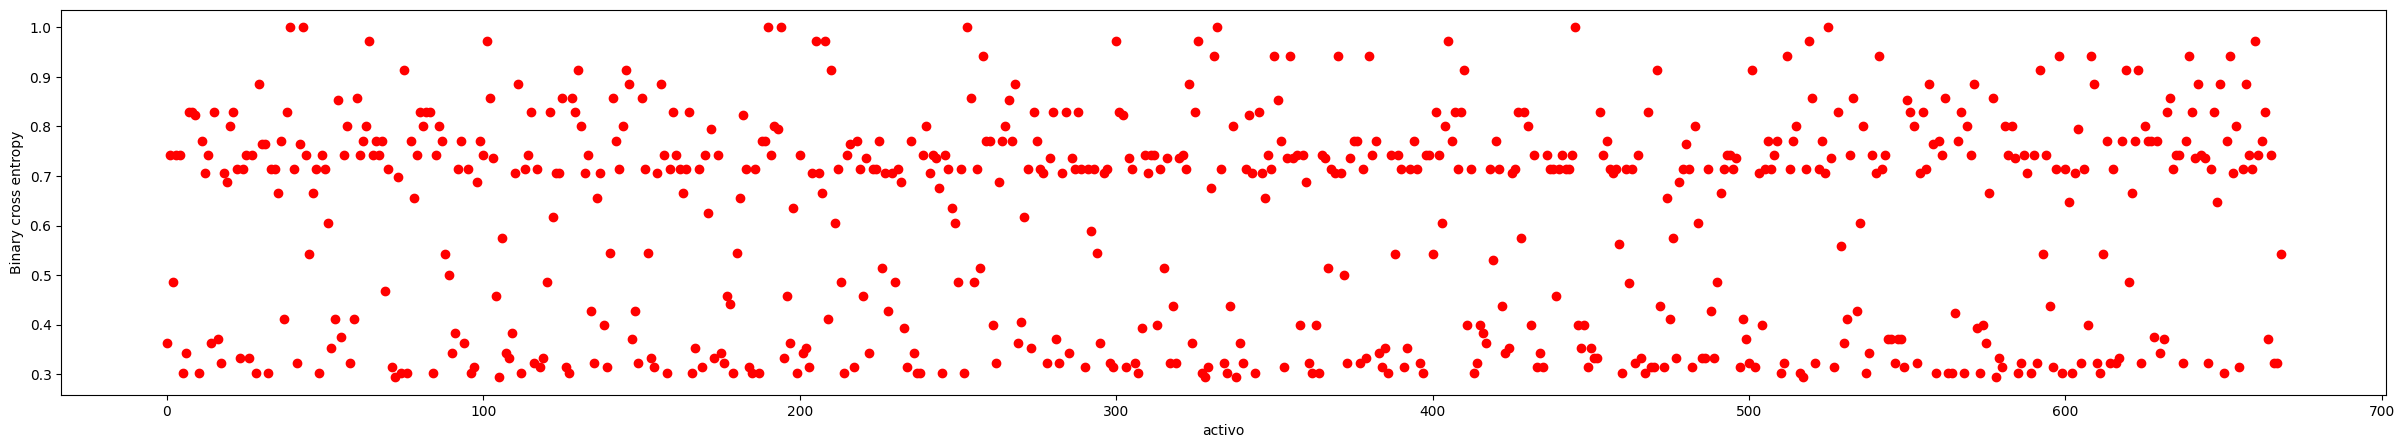

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_acurracy_manipulado_1,  color='red',  label='Accuracy Manipulado', marker='o', linestyle='none')

ax.set_xlabel("activo")
ax.set_ylabel("Binary cross entropy")

plt.show()

### Ver media acumulada

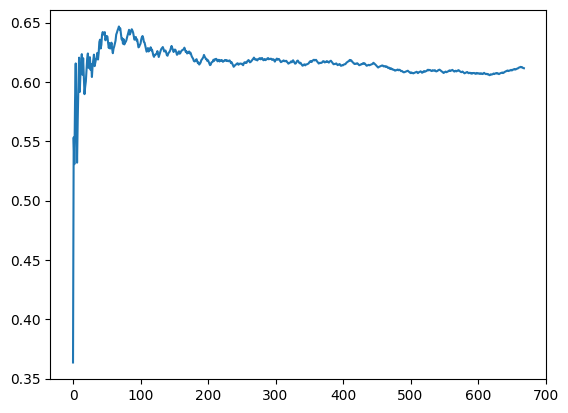

In [ ]:
## Ver media acumulada
ver_media_acumulada(h_acurracy_manipulado_1)

## Manipulacion 2

###Mascara 2

In [ ]:
def mascara_2(activos):

    # Crear un array de prueba de forma (35, 12)
  data = np.random.rand(activos, 12)

  # Crear una máscara de longitud 12 con 6 unos y 6 ceros
  mask = np.array([1]*6 + [0]*6)
  np.random.shuffle(mask)

  # Extender la máscara para que tenga la misma forma que data
  full_mask = np.tile(mask, (activos, 1))

  return full_mask

In [ ]:
mascara_2(4), mascara_2(4)

(array([[1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]]),
 array([[0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1],
        [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]]))

In [ ]:
_, h_acurracy_manipulado_2 = run_test_manipulados(mascara_2)

### Ver resultados

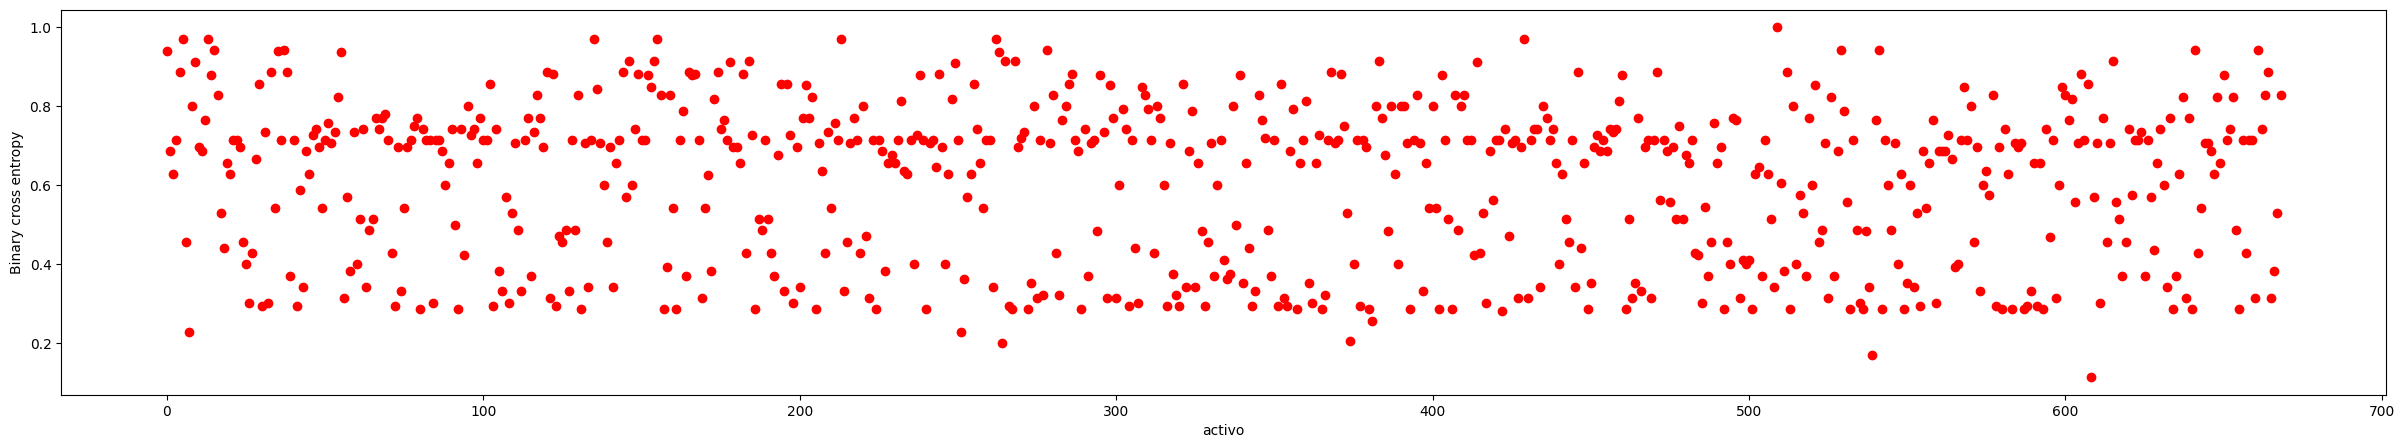

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_acurracy_manipulado_2,  color='red',  label='Accuracy Manipulado', marker='o', linestyle='none')

ax.set_xlabel("activo")
ax.set_ylabel("Binary cross entropy")

plt.show()

### Ver media acumulada

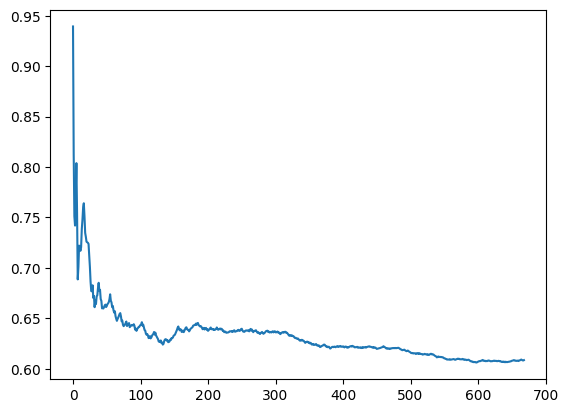

In [ ]:
## Ver media acumulada
ver_media_acumulada(h_acurracy_manipulado_2)

##Manipulacion 3

### Mascara 3

In [ ]:
def mascara_3(n_activos):

  # Crear un array de prueba de forma (35, 12)
  data = np.random.rand(n_activos, 12)
  # Crear una máscara de unos con la misma forma que data
  mask = np.ones_like(data)

  # Establecer 6 características aleatoriamente a 0 para cada activo
  for row in mask:
      zero_indices = np.random.choice(12, 6, replace=False)  # seleccionar aleatoriamente 6 características
      row[zero_indices] = 0

  return mask


In [ ]:
mascara_3(4), mascara_3(4)

(array([[1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.]]),
 array([[0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.],
        [0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.]]))

In [ ]:
h_accuracy, h_acurracy_manipulado_3 = run_test_manipulados(mascara_3)

### Ver resultados

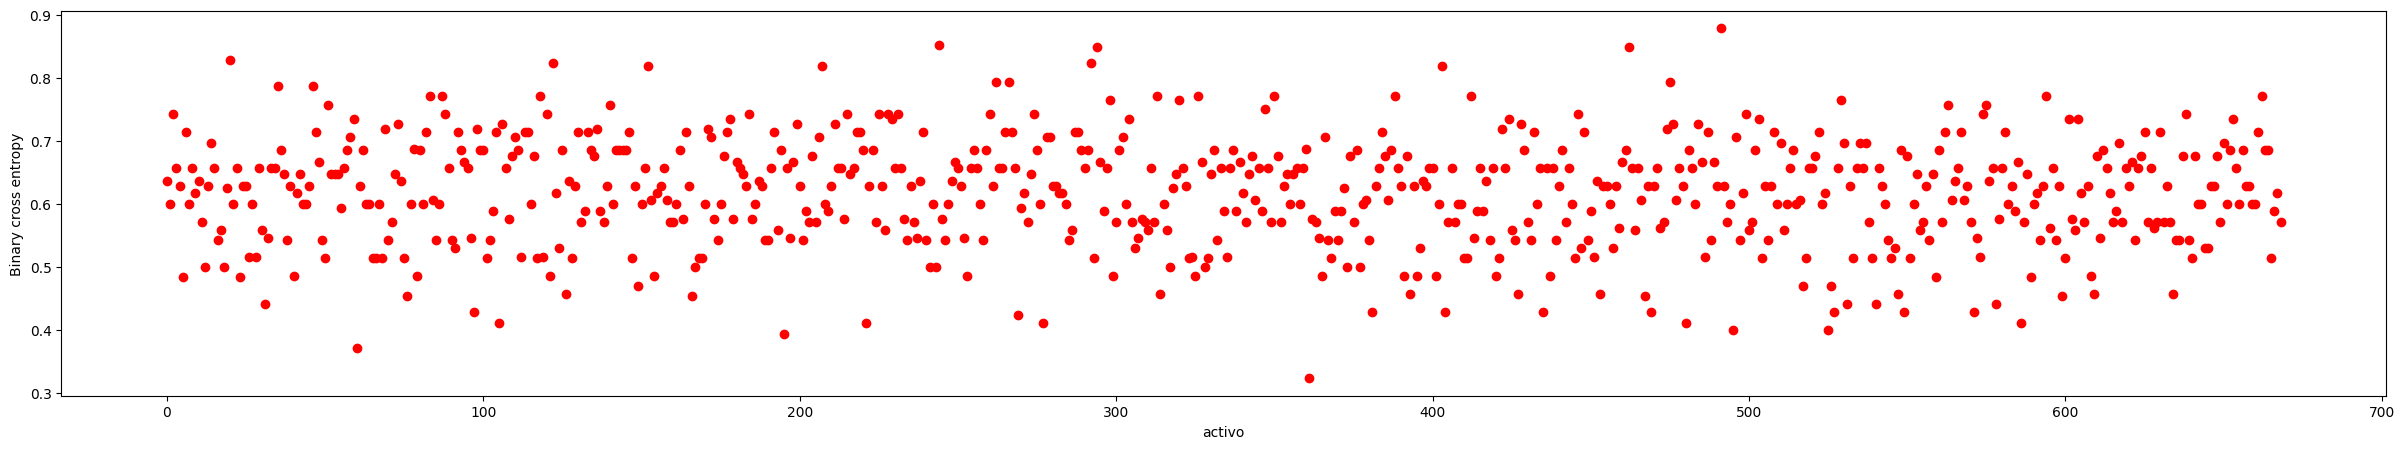

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_acurracy_manipulado_3,  color='red',  label='Accuracy Manipulado', marker='o', linestyle='none')

ax.set_xlabel("activo")
ax.set_ylabel("Binary cross entropy")

plt.show()

### Ver media acumulada

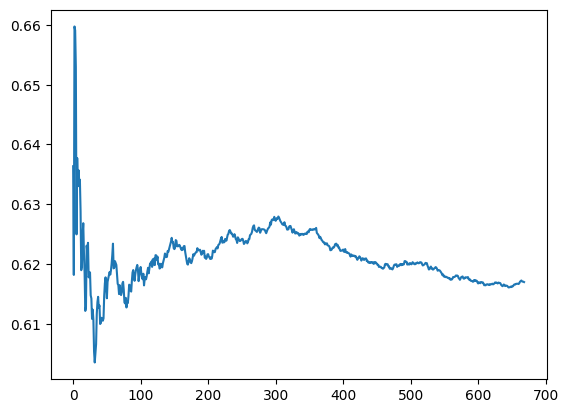

In [ ]:
## Ver media acumulada
ver_media_acumulada(h_acurracy_manipulado_3)

## Manipulacion 4

### Mascara 4

In [ ]:
def mascara_4(n_activos, n_features = 11, valor_sustituto = 0):

  # Crear un array de prueba de forma (35, 12)
  data = np.random.rand(n_activos, 12)
  # Crear una máscara de unos con la misma forma que data
  mask = np.ones_like(data)

  # Establecer n_features aleatoriamente a 0 para cada activo
  for row in mask:
      zero_indices = np.random.choice(12, n_features, replace=False)  # seleccionar aleatoriamente 6 características
      row[zero_indices] = valor_sustituto

  return mask

In [ ]:
mascara_4(4), mascara_4(4)

(array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]))

In [ ]:
h_accuracy, h_acurracy_manipulado_4 = run_test_manipulados(mascara_4)

### Ver resultados

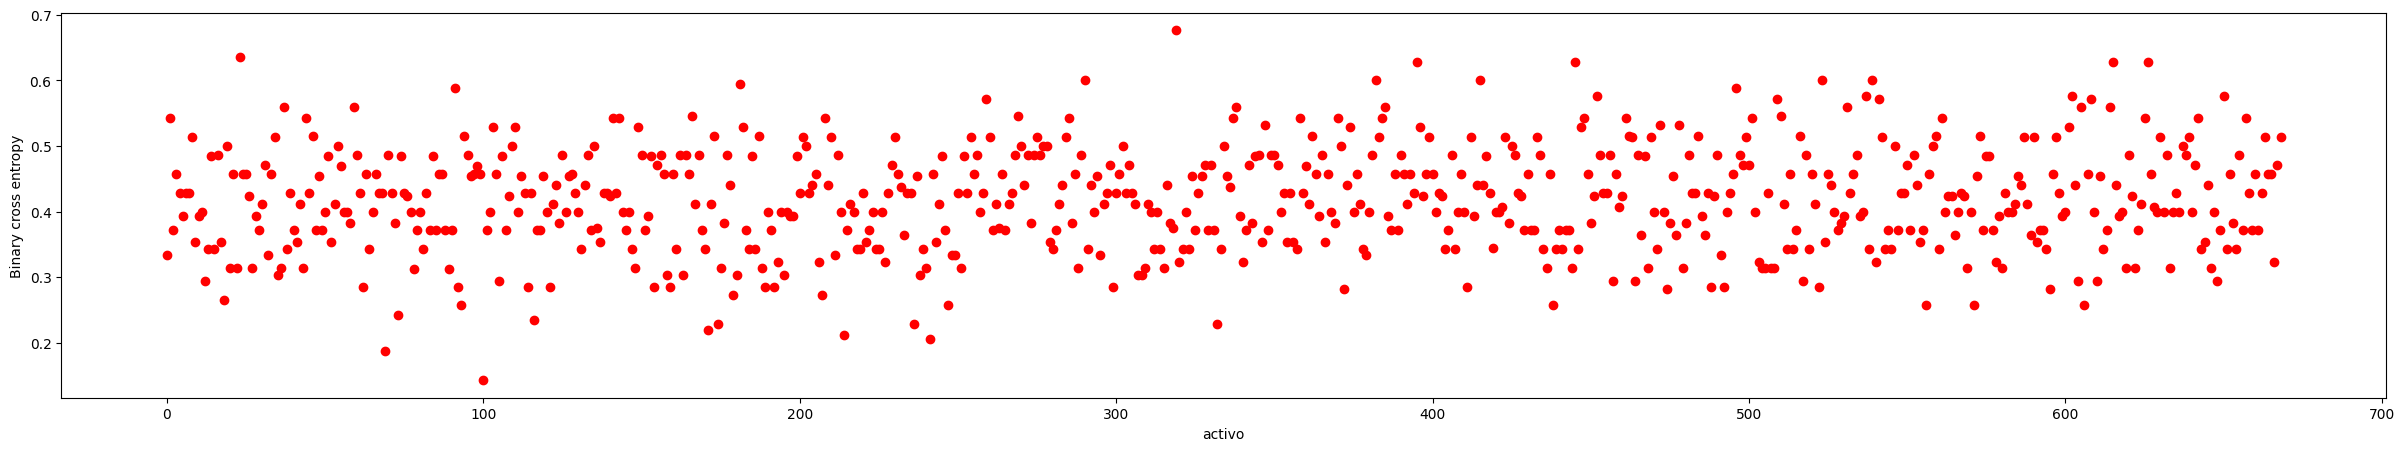

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_acurracy_manipulado_4,  color='red',  label='Accuracy Manipulado', marker='o', linestyle='none')

ax.set_xlabel("activo")
ax.set_ylabel("Binary cross entropy")

plt.show()

### Ver media acumulada

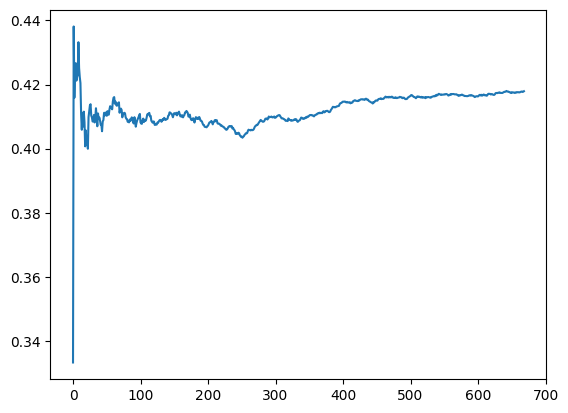

In [ ]:
## Ver media acumulada
ver_media_acumulada(h_acurracy_manipulado_4)

# Datos de accuracy del modelo y manipulaciones ( mean, max , min )

In [ ]:
np.array(h_acurracy).mean(),np.array(h_acurracy_manipulado_1).mean(),  np.array(h_acurracy_manipulado_2).mean(), np.array(h_acurracy_manipulado_3).mean() , np.array(h_acurracy_manipulado_4).mean()

(0.7752306075983866,
 0.6115423605235001,
 0.6085709089995558,
 0.6169855491455993,
 0.41790700415238796)

In [ ]:
np.array(h_acurracy).max(),np.array(h_acurracy_manipulado_1).max(),  np.array(h_acurracy_manipulado_2).max(), np.array(h_acurracy_manipulado_3).max(), np.array(h_acurracy_manipulado_4).max()

(1.0, 1.0, 1.0, 0.8787878787878788, 0.6764705882352942)

In [ ]:
np.array(h_acurracy).min(),np.array(h_acurracy_manipulado_1).min(),  np.array(h_acurracy_manipulado_2).min(), np.array(h_acurracy_manipulado_3).min(), np.array(h_acurracy_manipulado_4).min()

(0.42857142857142855,
 0.29411764705882354,
 0.11428571428571428,
 0.3235294117647059,
 0.14285714285714285)

La mascara 4 parece la que mas reduce la performance del modelo, asi que la primera copeticion entre modelo fijo y modelo evoolutivo sera con ella.

# ---- > MODELO FIJO VS MODELO EVOLUTIVO  < ----

Para que la competicion sea justa ambos empiezan con el mismo modelo.

Sabemos el minimo val_accuracy del modelo con los datos sin modificar es 0.42. Lo usaremos de referencia.

Contaremos las veces que el valor acuracy bajo de ese valor de referencia.

Cada X dias entrenaremos ambos modelos con los nuevos datos, si el evolutivo alcanzo el umbral de fallos evolucinara.

La busqueda de un modelo evolutiva es costosa en tiempo y por eso se limita a comprobar cada x dias, coincidiendo con los entrenamientos.

## proceso_evolucion (def)

In [ ]:
def proceso_evolucion(X_train, Y_train ):

  print("Proceso Evolucion ")
  #1
  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  X_train, Y_train,
  pop = create_model().crear_population(50),
  n_generations = 2,
  n_epochs = 250,
  n_best_pop = 1,
  n_parents = 10,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.5,
  n_immigration_population = 20,
  n_callback_patience = 10
  )
  print("Proceso Evolucion_1 ", best_global_fitness)
  #2
  """
  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  X_train, Y_train,
  pop = new_pop,
  n_generations = 5,
  #n_initial_population = 18,
  n_epochs = 500,
  n_best_pop = 3,
  n_parents = 6,
  n_chance_flip_crossover = 0.5,
  n_chance_flip_mutation = 0.25,
  n_immigration_population = 0,
  n_callback_patience = 20
  )
  """
  print("Proceso Evolucion_2 ", best_global_fitness)
  """"
  #3

  best_global_individual, best_global_fitness, h_pop, h_parents_pop, h_best_pop, new_pop,  h_layers, h_params = evo_get_model(
  pop = new_pop,
  n_generations = 20,
  n_epochs = 500,
  n_best_pop = 1,
  n_parents = 2,
  n_chance_flip_crossover = 0.25,
  n_chance_flip_mutation = 0.10,
  n_immigration_population = 0,
  n_callback_patience = 20
  )
  print("Proceso Evolucion_2 ", best_global_fitness)
  """

  _ = create_model()
  model_a = _.create_model(
      np.array(best_global_individual),
      X_train.shape[1:],
      1)

  early_stopping = EarlyStopping(monitor='val_accuracy', patience = 50, verbose=1, restore_best_weights=True)

  history_model_a = model_a.fit(
                              X_train,
                              Y_train,
                              epochs=1000,
                              batch_size= X_train.shape[0],
                              validation_split = 0.3,
                              verbose=1,
                              shuffle = True,
                              callbacks=[early_stopping]
                              )

  return model_a

In [ ]:
df_test.iloc[:, 2:14].head()

period_mean_return  period_std_return  period_min_return  \
12507            0.001878           0.019079          -0.029343   
12508            0.002509           0.019232          -0.029343   
12509            0.002084           0.018636          -0.029343   
12510           -0.000012           0.016237          -0.029343   
12511           -0.000084           0.016221          -0.029343   

       period_max_return  sharpe_ratio  sortino_ratio      beta  \
12507           0.051768      0.054429       0.096996  0.940494   
12508           0.051768      0.084160       0.151020  0.949047   
12509           0.051768      0.065679       0.114409  0.888067   
12510           0.032875     -0.053704      -0.079857  0.723101   
12511           0.032875     -0.058185      -0.086431  0.722240   

       treynor_ratio  benchmark_distance  informatio_ratio  \
12507       0.001997            0.015735          0.073656   
12508       0.002643            0.015963          0.126516   
12509       0.002347            0.014820          0.038311   
12510      -0.000017            0.013931         -0.070089   
12511      -0.000116            0.013926         -0.075156   

       modigliani_measure  alfa_jensen  
12507            0.001446     0.000909  
12508            0.001824     0.001221  
12509            0.001678     0.001799  
12510            0.000217    -0.000786  
12511            0.000164    -0.000859

In [ ]:
df_test.head()

ticker       date  period_mean_return  period_std_return  \
12507    ACS 2021-01-04            0.001878           0.019079   
12508    ACS 2021-01-05            0.002509           0.019232   
12509    ACS 2021-01-06            0.002084           0.018636   
12510    ACS 2021-01-07           -0.000012           0.016237   
12511    ACS 2021-01-08           -0.000084           0.016221   

       period_min_return  period_max_return  sharpe_ratio  sortino_ratio  \
12507          -0.029343           0.051768      0.054429       0.096996   
12508          -0.029343           0.051768      0.084160       0.151020   
12509          -0.029343           0.051768      0.065679       0.114409   
12510          -0.029343           0.032875     -0.053704      -0.079857   
12511          -0.029343           0.032875     -0.058185      -0.086431   

           beta  treynor_ratio  benchmark_distance  informatio_ratio  \
12507  0.940494       0.001997            0.015735          0.073656   
12508  0.949047       0.002643            0.015963          0.126516   
12509  0.888067       0.002347            0.014820          0.038311   
12510  0.723101      -0.000017            0.013931         -0.070089   
12511  0.722240      -0.000116            0.013926         -0.075156   

       modigliani_measure  alfa_jensen  label  
12507            0.001446     0.000909      0  
12508            0.001824     0.001221      1  
12509            0.001678     0.001799      0  
12510            0.000217    -0.000786      0  
12511            0.000164    -0.000859      0

In [ ]:
result_df.shape

(280, 15)

In [ ]:
df_train.shape

(186365, 15)

In [ ]:
data_vs = df_test.copy()
data_vs.iloc[:, 2:14] = scaler.transform(data_vs.iloc[:, 2:14])

In [ ]:

fechas_para_iterar = sorted(set(data_vs.date))
# Entrenaremos cada x dias
contador_entrenamiento = 0
dias_para_entrenar = 60

for day in fechas_para_iterar:

  contador_entrenamiento += 1
  if contador_entrenamiento >= dias_para_entrenar :
    contador_entrenamiento = 0

    datos_dia = data_vs[data_vs.date < str(day.date())]
    print("datos_dia",datos_dia.shape)

    muestra_train = df_train.sample(datos_dia.shape[0])
    print("muestra_train",muestra_train.shape)

    result = pd.concat([datos_dia, muestra_train], axis=1)

    print("result",result.shape)


datos_dia (2065, 15)
muestra_train (2065, 15)
result (4130, 30)
datos_dia (4134, 15)
muestra_train (4134, 15)
result (8268, 30)
datos_dia (6234, 15)
muestra_train (6234, 15)
result (12468, 30)
datos_dia (8334, 15)
muestra_train (8334, 15)
result (16668, 30)
datos_dia (10404, 15)
muestra_train (10404, 15)
result (20808, 30)
datos_dia (12504, 15)
muestra_train (12504, 15)
result (25008, 30)
datos_dia (14514, 15)
muestra_train (14514, 15)
result (29028, 30)
datos_dia (16614, 15)
muestra_train (16614, 15)
result (33228, 30)
datos_dia (18676, 15)
muestra_train (18676, 15)
result (37352, 30)
datos_dia (20688, 15)
muestra_train (20688, 15)
result (41376, 30)
datos_dia (22668, 15)
muestra_train (22668, 15)
result (45336, 30)


## Ejecutamos VS

2021-01-04
Fechas: 2021-01-04 - 2021-01-04
Fallos: 1
2021-01-05
Fechas: 2021-01-05 - 2021-01-05
Fallos: 2
2021-01-06
Fechas: 2021-01-06 - 2021-01-06
Fallos: 3
2021-01-07
Fechas: 2021-01-07 - 2021-01-07
Fallos: 4
2021-01-08
Fechas: 2021-01-08 - 2021-01-08
Fallos: 5
2021-01-11
Fechas: 2021-01-11 - 2021-01-11
Fallos: 6
2021-01-12
Fechas: 2021-01-12 - 2021-01-12
Fallos: 7
2021-01-13
Fechas: 2021-01-13 - 2021-01-13
Fallos: 8
2021-01-14
Fechas: 2021-01-14 - 2021-01-14
Fallos: 9
2021-01-15
Fechas: 2021-01-15 - 2021-01-15
Fallos: 10
2021-01-18
Fechas: 2021-01-18 - 2021-01-18
Fallos: 11
2021-01-19
Fechas: 2021-01-19 - 2021-01-19
Fallos: 12
2021-01-20
Fechas: 2021-01-20 - 2021-01-20
Fallos: 13
2021-01-21
Fechas: 2021-01-21 - 2021-01-21
Fallos: 14
2021-01-22
Fechas: 2021-01-22 - 2021-01-22
Fallos: 15
2021-01-25
Fechas: 2021-01-25 - 2021-01-25
Fallos: 16
2021-01-26
Fechas: 2021-01-26 - 2021-01-26
Fallos: 17
2021-01-27
Fechas: 2021-01-27 - 2021-01-27
Fallos: 18
2021-01-28
Fechas: 2021-01-28 - 2021-

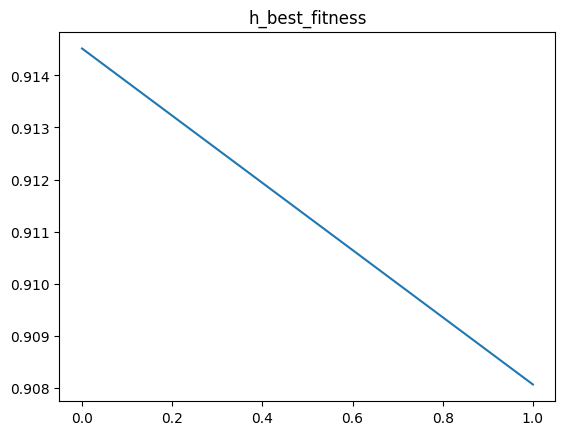

Proceso Evolucion_1  0.9145161509513855
Proceso Evolucion_2  0.9145161509513855
Epoch 1/1000
1/1 [==============================] - 1s 961ms/step - loss: 7.9459 - accuracy: 0.7336 - val_loss: 7.6772 - val_accuracy: 0.6694
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.6763 - accuracy: 0.7336 - val_loss: 7.3912 - val_accuracy: 0.6694
Epoch 3/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.3629 - accuracy: 0.7336 - val_loss: 7.1148 - val_accuracy: 0.6694
Epoch 4/1000
1/1 [==============================] - 0s 32ms/step - loss: 7.1053 - accuracy: 0.7336 - val_loss: 6.8485 - val_accuracy: 0.6694
Epoch 5/1000
1/1 [==============================] - 0s 30ms/step - loss: 6.8490 - accuracy: 0.7336 - val_loss: 6.5914 - val_accuracy: 0.6694
Epoch 6/1000
1/1 [==============================] - 0s 30ms/step - loss: 6.5921 - accuracy: 0.7336 - val_loss: 6.3434 - val_accuracy: 0.6694
Epoch 7/1000
1/1 [==============================] - 0s 30ms/step - loss: 

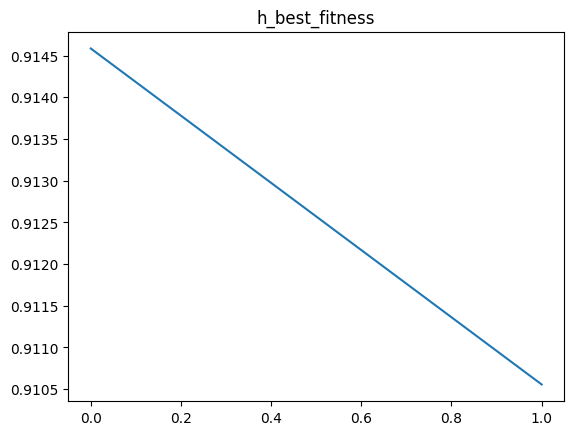

Proceso Evolucion_1  0.9145849943161011
Proceso Evolucion_2  0.9145849943161011
Epoch 1/1000
1/1 [==============================] - 1s 951ms/step - loss: 12.4363 - accuracy: 0.3457 - val_loss: 11.9164 - val_accuracy: 0.5850
Epoch 2/1000
1/1 [==============================] - 0s 35ms/step - loss: 11.9007 - accuracy: 0.5859 - val_loss: 11.3979 - val_accuracy: 0.6076
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 11.3836 - accuracy: 0.6723 - val_loss: 10.8973 - val_accuracy: 0.6317
Epoch 4/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.8848 - accuracy: 0.7273 - val_loss: 10.4149 - val_accuracy: 0.6745
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.4055 - accuracy: 0.7490 - val_loss: 9.9504 - val_accuracy: 0.7268
Epoch 6/1000
1/1 [==============================] - 0s 35ms/step - loss: 9.9419 - accuracy: 0.7871 - val_loss: 9.5033 - val_accuracy: 0.7534
Epoch 7/1000
1/1 [==============================] - 0s 38ms/step

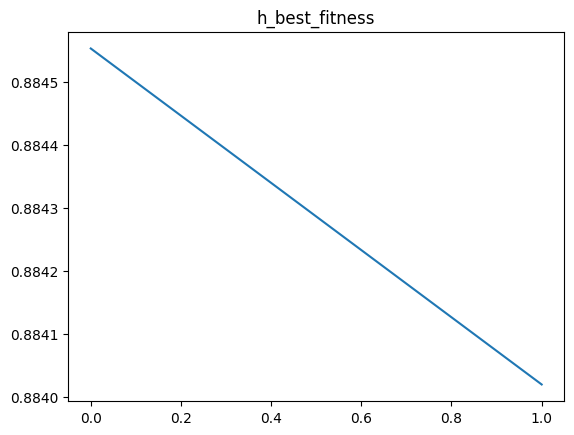

Proceso Evolucion_1  0.8845537304878235
Proceso Evolucion_2  0.8845537304878235
Epoch 1/1000
1/1 [==============================] - 1s 878ms/step - loss: 3.3988 - accuracy: 0.5492 - val_loss: 3.3044 - val_accuracy: 0.6996
Epoch 2/1000
1/1 [==============================] - 0s 35ms/step - loss: 3.3036 - accuracy: 0.7648 - val_loss: 3.2121 - val_accuracy: 0.6996
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 3.2111 - accuracy: 0.7465 - val_loss: 3.1222 - val_accuracy: 0.6996
Epoch 4/1000
1/1 [==============================] - 0s 32ms/step - loss: 3.1208 - accuracy: 0.7389 - val_loss: 3.0346 - val_accuracy: 0.6996
Epoch 5/1000
1/1 [==============================] - 0s 34ms/step - loss: 3.0329 - accuracy: 0.7355 - val_loss: 2.9494 - val_accuracy: 0.6996
Epoch 6/1000
1/1 [==============================] - 0s 33ms/step - loss: 2.9473 - accuracy: 0.7321 - val_loss: 2.8666 - val_accuracy: 0.6996
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 

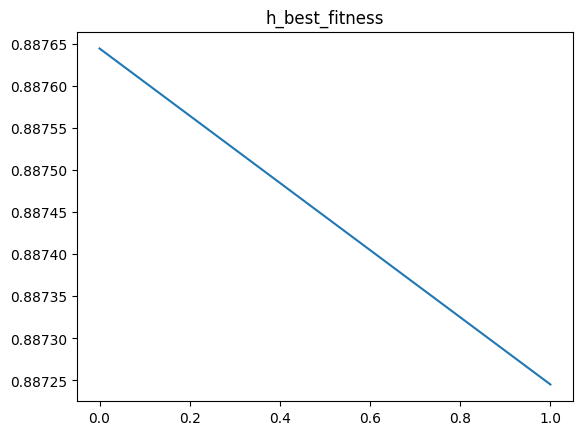

Proceso Evolucion_1  0.8876449465751648
Proceso Evolucion_2  0.8876449465751648
Epoch 1/1000
1/1 [==============================] - 1s 921ms/step - loss: 8.3258 - accuracy: 0.6707 - val_loss: 7.9564 - val_accuracy: 0.7041
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 8.0206 - accuracy: 0.6820 - val_loss: 7.6651 - val_accuracy: 0.7041
Epoch 3/1000
1/1 [==============================] - 0s 30ms/step - loss: 7.7301 - accuracy: 0.6834 - val_loss: 7.3810 - val_accuracy: 0.7041
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.4418 - accuracy: 0.6900 - val_loss: 7.1044 - val_accuracy: 0.7041
Epoch 5/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.1717 - accuracy: 0.6849 - val_loss: 6.8354 - val_accuracy: 0.7041
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 6.9010 - accuracy: 0.6894 - val_loss: 6.5746 - val_accuracy: 0.7041
Epoch 7/1000
1/1 [==============================] - 0s 34ms/step - loss: 

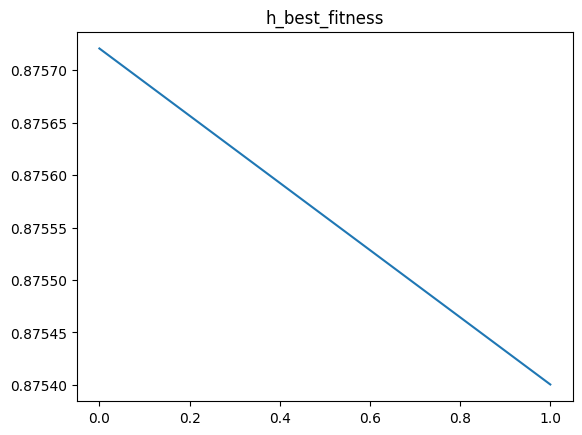

Proceso Evolucion_1  0.8757206797599792
Proceso Evolucion_2  0.8757206797599792
Epoch 1/1000
1/1 [==============================] - 1s 983ms/step - loss: 7.5486 - accuracy: 0.7240 - val_loss: 7.3540 - val_accuracy: 0.6883
Epoch 2/1000
1/1 [==============================] - 0s 35ms/step - loss: 7.3435 - accuracy: 0.7222 - val_loss: 7.1797 - val_accuracy: 0.6883
Epoch 3/1000
1/1 [==============================] - 0s 33ms/step - loss: 7.2245 - accuracy: 0.7230 - val_loss: 7.0083 - val_accuracy: 0.6883
Epoch 4/1000
1/1 [==============================] - 0s 38ms/step - loss: 7.0464 - accuracy: 0.7240 - val_loss: 6.8403 - val_accuracy: 0.6883
Epoch 5/1000
1/1 [==============================] - 0s 36ms/step - loss: 6.8821 - accuracy: 0.7240 - val_loss: 6.6757 - val_accuracy: 0.6883
Epoch 6/1000
1/1 [==============================] - 0s 34ms/step - loss: 6.6746 - accuracy: 0.7240 - val_loss: 6.5152 - val_accuracy: 0.6883
Epoch 7/1000
1/1 [==============================] - 0s 34ms/step - loss: 

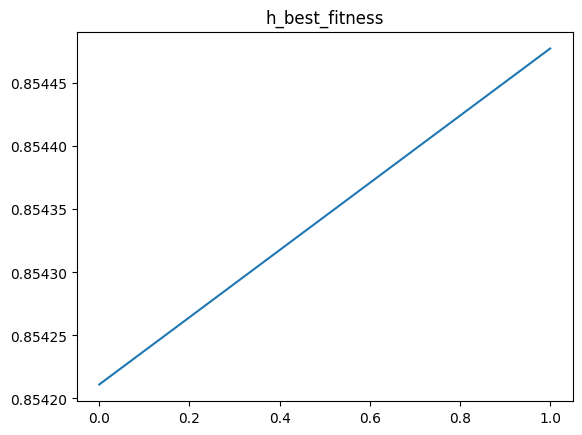

Proceso Evolucion_1  0.85447758436203
Proceso Evolucion_2  0.85447758436203
Epoch 1/1000
1/1 [==============================] - 1s 924ms/step - loss: 1.1652 - accuracy: 0.7307 - val_loss: 1.1520 - val_accuracy: 0.6714
Epoch 2/1000
1/1 [==============================] - 0s 36ms/step - loss: 1.1486 - accuracy: 0.7307 - val_loss: 1.1355 - val_accuracy: 0.6714
Epoch 3/1000
1/1 [==============================] - 0s 37ms/step - loss: 1.1324 - accuracy: 0.7307 - val_loss: 1.1199 - val_accuracy: 0.6714
Epoch 4/1000
1/1 [==============================] - 0s 37ms/step - loss: 1.1169 - accuracy: 0.7307 - val_loss: 1.1051 - val_accuracy: 0.6714
Epoch 5/1000
1/1 [==============================] - 0s 41ms/step - loss: 1.1020 - accuracy: 0.7307 - val_loss: 1.0910 - val_accuracy: 0.6714
Epoch 6/1000
1/1 [==============================] - 0s 42ms/step - loss: 1.0875 - accuracy: 0.7307 - val_loss: 1.0771 - val_accuracy: 0.6714
Epoch 7/1000
1/1 [==============================] - 0s 39ms/step - loss: 1.07

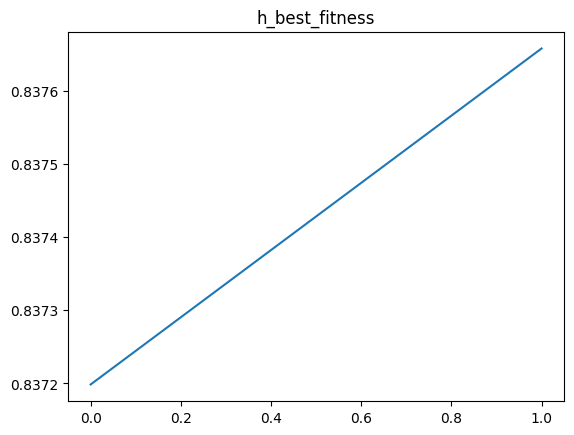

Proceso Evolucion_1  0.8376578688621521
Proceso Evolucion_2  0.8376578688621521
Epoch 1/1000
1/1 [==============================] - 1s 777ms/step - loss: 6.3511 - accuracy: 0.7298 - val_loss: 6.1448 - val_accuracy: 0.8264
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.1569 - accuracy: 0.7302 - val_loss: 5.9587 - val_accuracy: 0.8191
Epoch 3/1000
1/1 [==============================] - 0s 34ms/step - loss: 5.9687 - accuracy: 0.7304 - val_loss: 5.7765 - val_accuracy: 0.7685
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 5.7816 - accuracy: 0.7325 - val_loss: 5.5988 - val_accuracy: 0.7270
Epoch 5/1000
1/1 [==============================] - 0s 30ms/step - loss: 5.6004 - accuracy: 0.7313 - val_loss: 5.4254 - val_accuracy: 0.7017
Epoch 6/1000
1/1 [==============================] - 0s 31ms/step - loss: 5.4269 - accuracy: 0.7315 - val_loss: 5.2562 - val_accuracy: 0.6877
Epoch 7/1000
1/1 [==============================] - 0s 32ms/step - loss: 

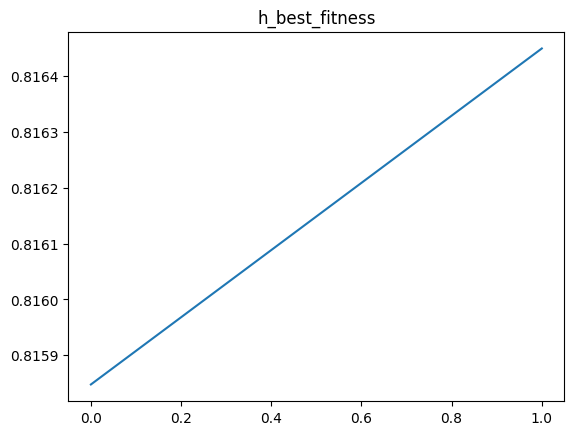

Proceso Evolucion_1  0.8164493441581726
Proceso Evolucion_2  0.8164493441581726
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 13.6713 - accuracy: 0.6155 - val_loss: 13.1080 - val_accuracy: 0.6638
Epoch 2/1000
1/1 [==============================] - 0s 36ms/step - loss: 13.1120 - accuracy: 0.6827 - val_loss: 12.5704 - val_accuracy: 0.6638
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 12.5745 - accuracy: 0.6991 - val_loss: 12.0505 - val_accuracy: 0.6638
Epoch 4/1000
1/1 [==============================] - 0s 37ms/step - loss: 12.0512 - accuracy: 0.7222 - val_loss: 11.5474 - val_accuracy: 0.6638
Epoch 5/1000
1/1 [==============================] - 0s 38ms/step - loss: 11.5465 - accuracy: 0.7341 - val_loss: 11.0612 - val_accuracy: 0.6638
Epoch 6/1000
1/1 [==============================] - 0s 38ms/step - loss: 11.0579 - accuracy: 0.7398 - val_loss: 10.5908 - val_accuracy: 0.6638
Epoch 7/1000
1/1 [==============================] - 0s 36ms/step

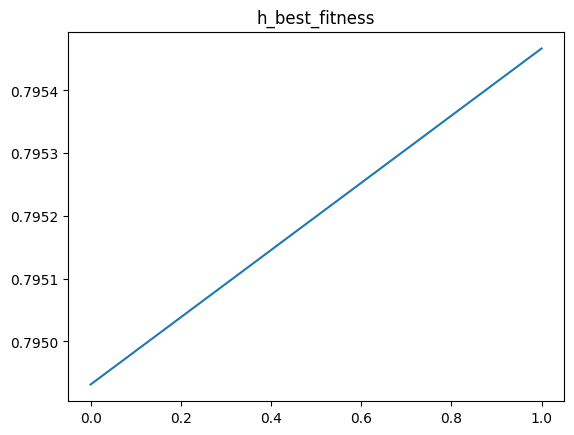

Proceso Evolucion_1  0.7954667210578918
Proceso Evolucion_2  0.7954667210578918
Epoch 1/1000
1/1 [==============================] - 1s 674ms/step - loss: 5.9634 - accuracy: 0.6892 - val_loss: 5.7023 - val_accuracy: 0.4598
Epoch 2/1000
1/1 [==============================] - 0s 34ms/step - loss: 5.7202 - accuracy: 0.6987 - val_loss: 5.4694 - val_accuracy: 0.5179
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 5.4811 - accuracy: 0.7034 - val_loss: 5.2453 - val_accuracy: 0.5333
Epoch 4/1000
1/1 [==============================] - 0s 35ms/step - loss: 5.2558 - accuracy: 0.7073 - val_loss: 5.0301 - val_accuracy: 0.5376
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: 5.0411 - accuracy: 0.7080 - val_loss: 4.8237 - val_accuracy: 0.5549
Epoch 6/1000
1/1 [==============================] - 0s 34ms/step - loss: 4.8284 - accuracy: 0.7136 - val_loss: 4.6258 - val_accuracy: 0.5763
Epoch 7/1000
1/1 [==============================] - 0s 33ms/step - loss: 

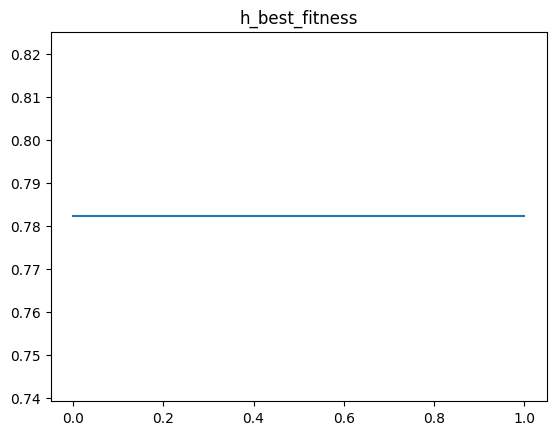

Proceso Evolucion_1  0.7821813821792603
Proceso Evolucion_2  0.7821813821792603
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 15.6553 - accuracy: 0.6811 - val_loss: 14.9818 - val_accuracy: 0.6717
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 15.0749 - accuracy: 0.7179 - val_loss: 14.4208 - val_accuracy: 0.6717
Epoch 3/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.4949 - accuracy: 0.7305 - val_loss: 13.8756 - val_accuracy: 0.6717
Epoch 4/1000
1/1 [==============================] - 0s 33ms/step - loss: 13.9448 - accuracy: 0.7250 - val_loss: 13.3463 - val_accuracy: 0.6717
Epoch 5/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.4044 - accuracy: 0.7276 - val_loss: 12.8322 - val_accuracy: 0.6717
Epoch 6/1000
1/1 [==============================] - 0s 32ms/step - loss: 12.8605 - accuracy: 0.7294 - val_loss: 12.3336 - val_accuracy: 0.6717
Epoch 7/1000
1/1 [==============================] - 0s 35ms/step

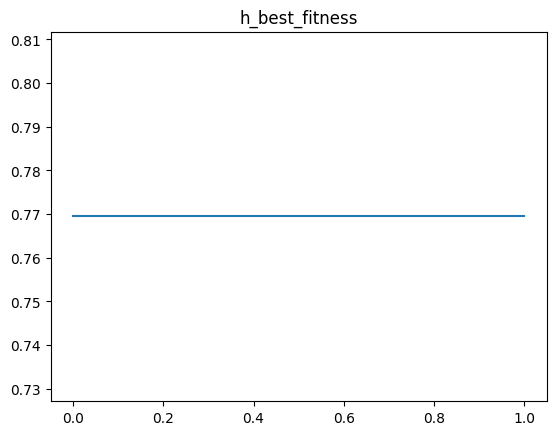

Proceso Evolucion_1  0.7694456577301025
Proceso Evolucion_2  0.7694456577301025
Epoch 1/1000
1/1 [==============================] - 1s 791ms/step - loss: 8.5196 - accuracy: 0.5900 - val_loss: 8.1190 - val_accuracy: 0.4930
Epoch 2/1000
1/1 [==============================] - 0s 37ms/step - loss: 8.1402 - accuracy: 0.6384 - val_loss: 7.7593 - val_accuracy: 0.5996
Epoch 3/1000
1/1 [==============================] - 0s 39ms/step - loss: 7.7766 - accuracy: 0.6595 - val_loss: 7.4140 - val_accuracy: 0.6748
Epoch 4/1000
1/1 [==============================] - 0s 36ms/step - loss: 7.4263 - accuracy: 0.6810 - val_loss: 7.0821 - val_accuracy: 0.7040
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: 7.0898 - accuracy: 0.6957 - val_loss: 6.7629 - val_accuracy: 0.7161
Epoch 6/1000
1/1 [==============================] - 0s 37ms/step - loss: 6.7657 - accuracy: 0.7160 - val_loss: 6.4558 - val_accuracy: 0.7111
Epoch 7/1000
1/1 [==============================] - 0s 38ms/step - loss: 

In [ ]:
data_vs = df_test.copy()
data_vs.iloc[:, 2:14] = scaler.transform(data_vs.iloc[:, 2:14])

mascara = mascara_1
# Dado que las mascaras son aleatorias crearemos una mascara para todo el dataset fija
mask_vs = mascara(data_vs.shape[0])
mask_vs = pd.DataFrame(mask_vs, index = data_vs.index)

# Modelos vs
model_fijo_datos_reales = load_model('best_model_0.h5')
model_fijo = load_model('best_model_0.h5')
model_evolutivo = load_model('best_model_0.h5')

# Entrenaremos cada x dias
contador_entrenamiento = 0
dias_para_entrenar = 60

# Contaremos el numero de vaces que el val_acurracy fue inferior a un nivel de referencia
contador_fallos_evolutivo = 0
nivel_de_referencia = 0.75
n_fallos_posibles = 15

h_accuracy_fijo_datos_reales = []
h_accuracy_fijo = []
h_acurracy_evolutivo = []
h_dia_entrenado = []
h_dia_evolucion = []
h_contador_fallos = []


fechas_para_iterar = sorted(set(data_vs.date))
for day in fechas_para_iterar:

  print(str(day.date()))
  h_dia_entrenado.append(0)
  h_dia_evolucion.append(0)

  # datos dia
  datos_dia = data_vs[data_vs.date == str(day.date())]
  print("Fechas:" , str(list(sorted(set(datos_dia.date)))[-1].date()) + " - " + str(list(sorted(set(datos_dia.date)))[0].date())  )
  indices_seleccionados = datos_dia.index

  y_true = np.array( datos_dia.iloc[:,-1] )
  x = datos_dia.iloc[:,2:-1]
  x = np.array(x)

  # Datos manipulados
  mascara_del_dia = mask_vs.loc[indices_seleccionados]
  mascara_del_dia = np.array(mascara_del_dia)

  x_manipulados = x * mascara_del_dia
  x_manipulados = np.array(x_manipulados)

  # ------ Preds & Acc ------

  # - Pred modelo fijo datos reales -

  y_pred = model_fijo_datos_reales(x)
  y_pred = y_pred.numpy().round(2).reshape(-1)
  y_pred_labels = (y_pred >= 0.5).astype(int)

  # Accuracy modelo fijo datos reales
  accuracy = np.mean(y_true == y_pred_labels)
  h_accuracy_fijo_datos_reales.append(accuracy)


  #  -Pred modelo fijo -

  y_pred = model_fijo(x_manipulados)
  y_pred = y_pred.numpy().round(2).reshape(-1)
  y_pred_labels = (y_pred >= 0.5).astype(int)

  # Accuracy modelo fijo
  accuracy = np.mean(y_true == y_pred_labels)
  h_accuracy_fijo.append(accuracy)

  #  -Pred modelo evolutivo -
  y_pred = model_evolutivo(x_manipulados)
  y_pred = y_pred.numpy().round(2).reshape(-1)
  y_pred_labels = (y_pred >= 0.5).astype(int)

  # Accuracy modelo evolutivo
  accuracy = np.mean(y_true == y_pred_labels)
  h_acurracy_evolutivo.append(accuracy)

  # Contador fallos evolutivo

  contador_fallos_evolutivo += ( h_acurracy_evolutivo[-1] < nivel_de_referencia ) * 1
  h_contador_fallos.append(contador_fallos_evolutivo)
  print("Fallos:", contador_fallos_evolutivo )

  # ------ ENTRENAMIENTO ------

  contador_entrenamiento += 1
  if contador_entrenamiento >= dias_para_entrenar :
    contador_entrenamiento = 0
    h_dia_entrenado[-1] = 1

    # datos entrenamiento
    datos_dia = data_vs[data_vs.date < str(day.date())]
    print("Fechas Train:" , str(list(sorted(set(datos_dia.date)))[-1].date()) + " - " + str(list(sorted(set(datos_dia.date)))[0].date())  )
    indices_seleccionados = datos_dia.index
    y_true = np.array( datos_dia.iloc[:,-1] )
    x = datos_dia.iloc[:,2:-1]
    x = np.array(x)

    # Datos manipulados
    mascara_del_hist = mask_vs.loc[indices_seleccionados]
    mascara_del_hist = np.array(mascara_del_hist)
    x_manipulados = x * mascara_del_hist

    # Entrenamos modelo fijo datos reales
    print("Entrenamos Fijo datos reales")

    earlystopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose = 1
    )

    model_fijo_datos_reales.fit(
          x, y_true,
          epochs=500,
          batch_size = x.shape[0],
          validation_split = 0.3,
          callbacks = [earlystopping],
          shuffle=True,
          verbose=False
            )


    # Entrenamos modelo fijo
    print("Entrenamos Fijo")

    earlystopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose = 1
    )

    model_fijo.fit(
        x_manipulados, y_true,
          epochs=500,
          batch_size = x.shape[0],
          validation_split = 0.3,
          callbacks = [earlystopping],
          shuffle=True,
          verbose=False
            )

    # ¿ Evolucinamos ?
    if contador_fallos_evolutivo > n_fallos_posibles:

      print("EVOLUCION")

      contador_fallos_evolutivo = 0
      h_dia_evolucion[-1] = 1

      model_evolutivo = proceso_evolucion(x_manipulados, y_true)

      early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose = 1
        )
      model_evolutivo.fit(
                    X_train,
                    Y_train,
                    epochs=1000,
                    batch_size= X_train.shape[0],
                    validation_split = 0.3,
                    verbose=1,
                    shuffle = True,
                    callbacks=[early_stopping]
                    )


    print("Entrenamos Evolutivo")

    # Entrenamos modelo evolutivo

    earlystopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose = 1
    )

    model_evolutivo.fit(
          x_manipulados, y_true,
          epochs=500,
          batch_size = x.shape[0],
          validation_split = 0.3,
          callbacks = [earlystopping],
          shuffle=True,
          verbose=False
          )



print("FIN")


In [ ]:
model_evolutivo.save('best_model_vs_0.h5')

Model: "model_1011"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 12)]              0         
                                                                 
 Densa_0 (Dense)             (None, 5)                 65        
                                                                 
 dropout_4982 (Dropout)      (None, 5)                 0         
                                                                 
 Densa_1 (Dense)             (None, 3)                 18        
                                                                 
 dropout_4983 (Dropout)      (None, 3)                 0         
                                                                 
 Densa_5 (Dense)             (None, 3)                 12        
                                                                 
 dropout_4985 (Dropout)      (None, 3)                 0

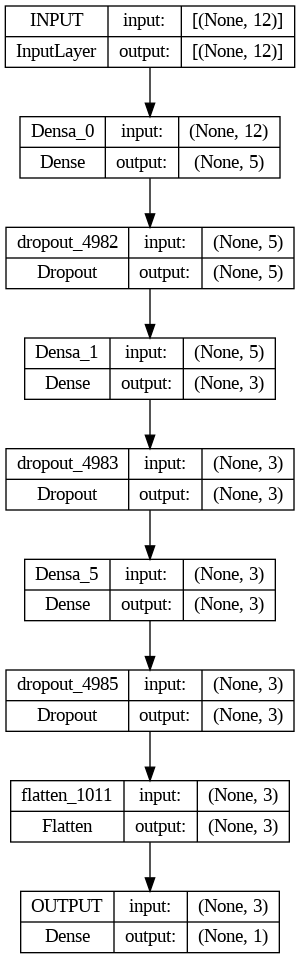

In [ ]:
model_evolutivo.summary()
plot_model(model_evolutivo, show_shapes=True, show_layer_names=True)

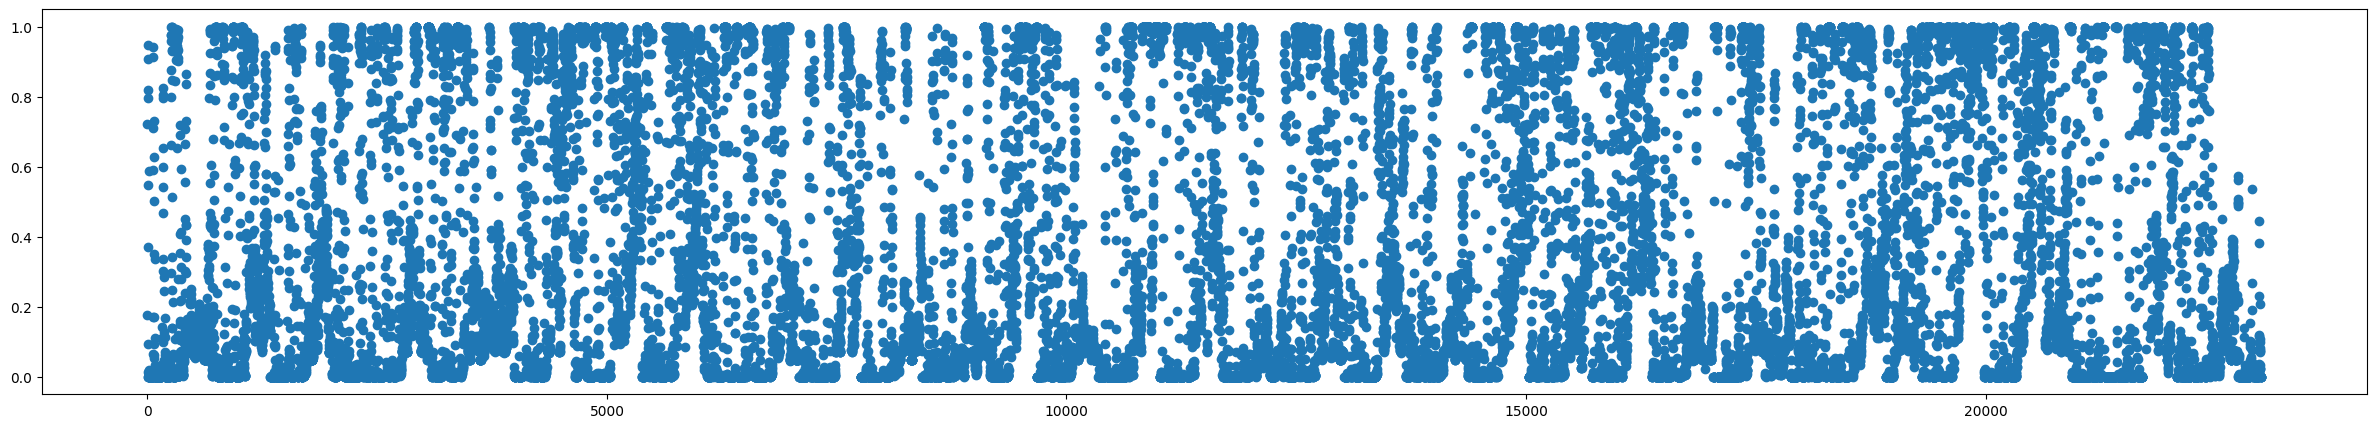

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(model_fijo(X_test), marker='o', linestyle='none')

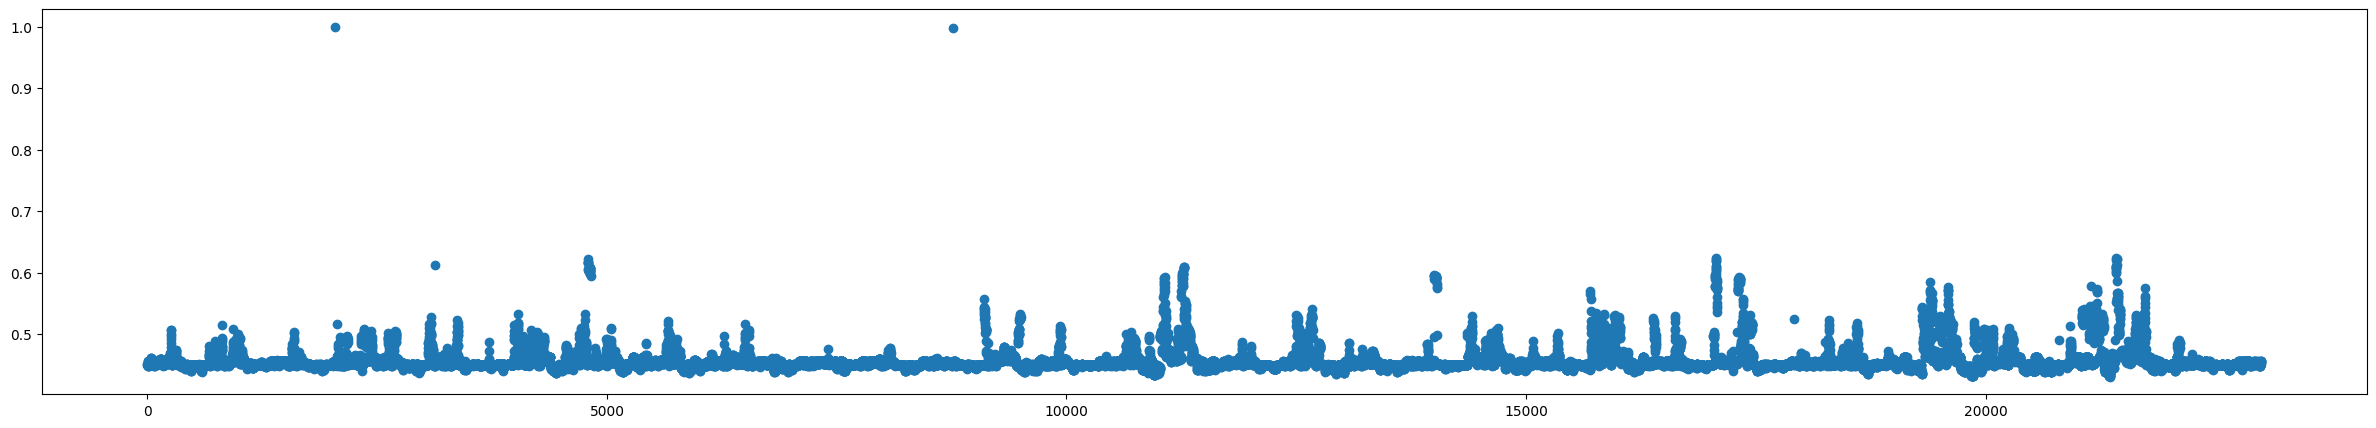

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(model_evolutivo(X_test), marker='o', linestyle='none')

### ver_performance (def)

In [ ]:
def ver_performance(h_acurracy_evolutivo ):
  # Tu array de valores
  data = np.array(h_acurracy_evolutivo)
  # Calcula la suma acumulativa
  cumulative_sum = np.cumsum(data)
  # Calcula la media acumulativa
  cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


  fig, ax = plt.subplots(figsize=(30,5))

  plt.plot( h_acurracy_evolutivo,  color='red',  label='h_acurracyo', marker='o', linestyle='none')

  plt.plot( cumulative_average ,  color='red')


  # Trazar líneas verticales azules donde h_dia_entrenado sea 1
  for i, value in enumerate(h_dia_entrenado):
      if value == 1:
          ax.axvline(x=i, color='blue', linestyle='--', alpha=0.7)
  # Trazar líneas verticales azules donde h_dia_evolucion sea 1
  for i, value in enumerate(h_dia_evolucion):
      if value == 1:
          ax.axvline(x=i, color='red', linestyle='--', alpha=0.7)


  ax.set_xlabel("dia")
  ax.set_ylabel("Binary cross entropy")

  plt.show()

### Ver resultados

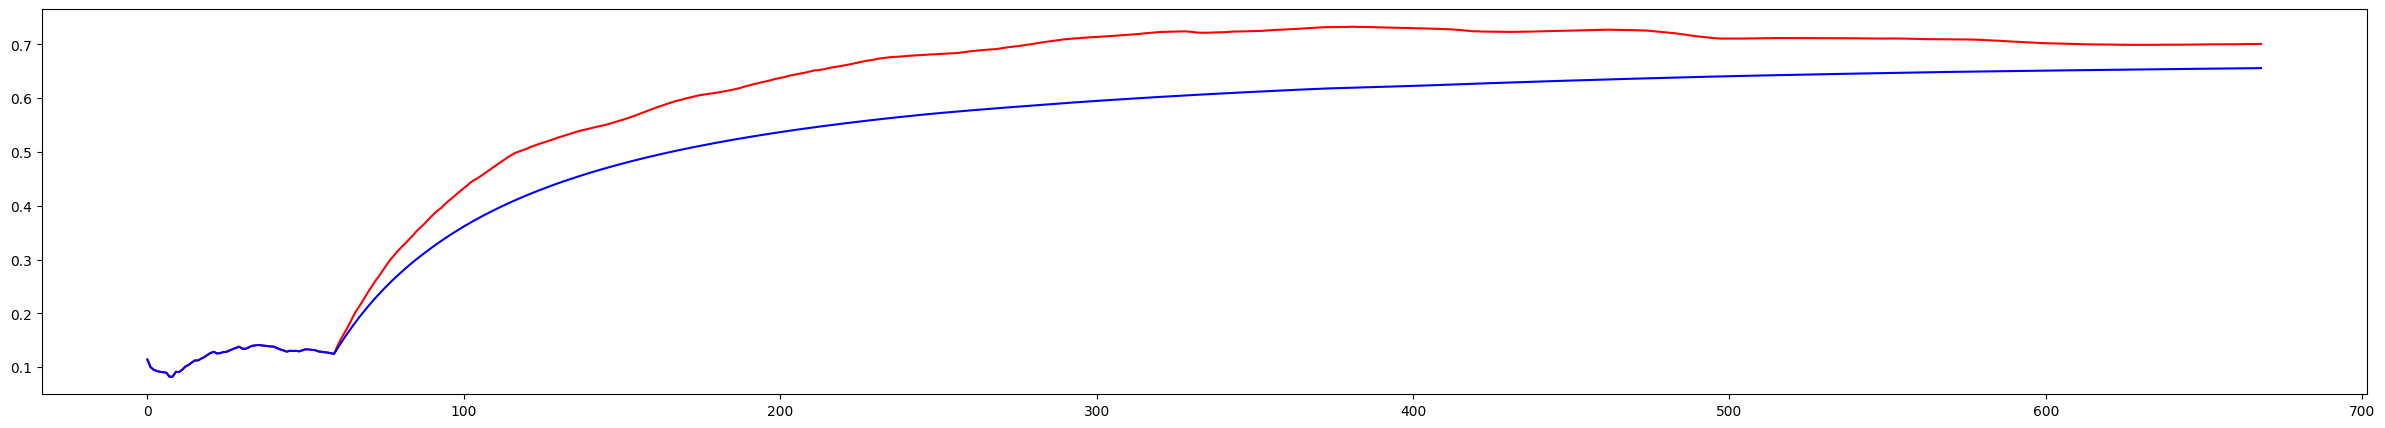

In [ ]:
 # Tu array de valores
data = np.array(h_accuracy_fijo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


fig, ax = plt.subplots(figsize=(30,5))

plt.plot( cumulative_average,  color='red')

 # Tu array de valores
data = np.array(h_acurracy_evolutivo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)


plt.plot( cumulative_average,  color='blue')


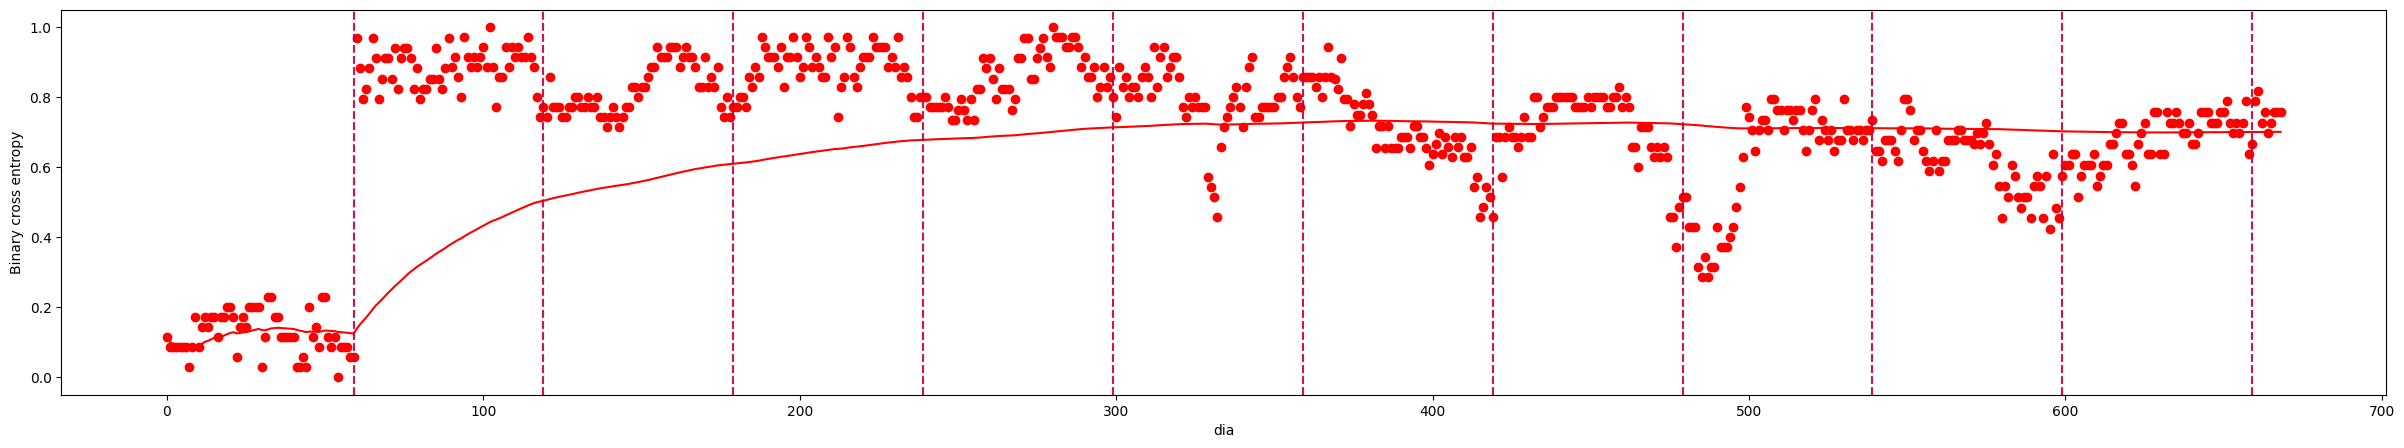

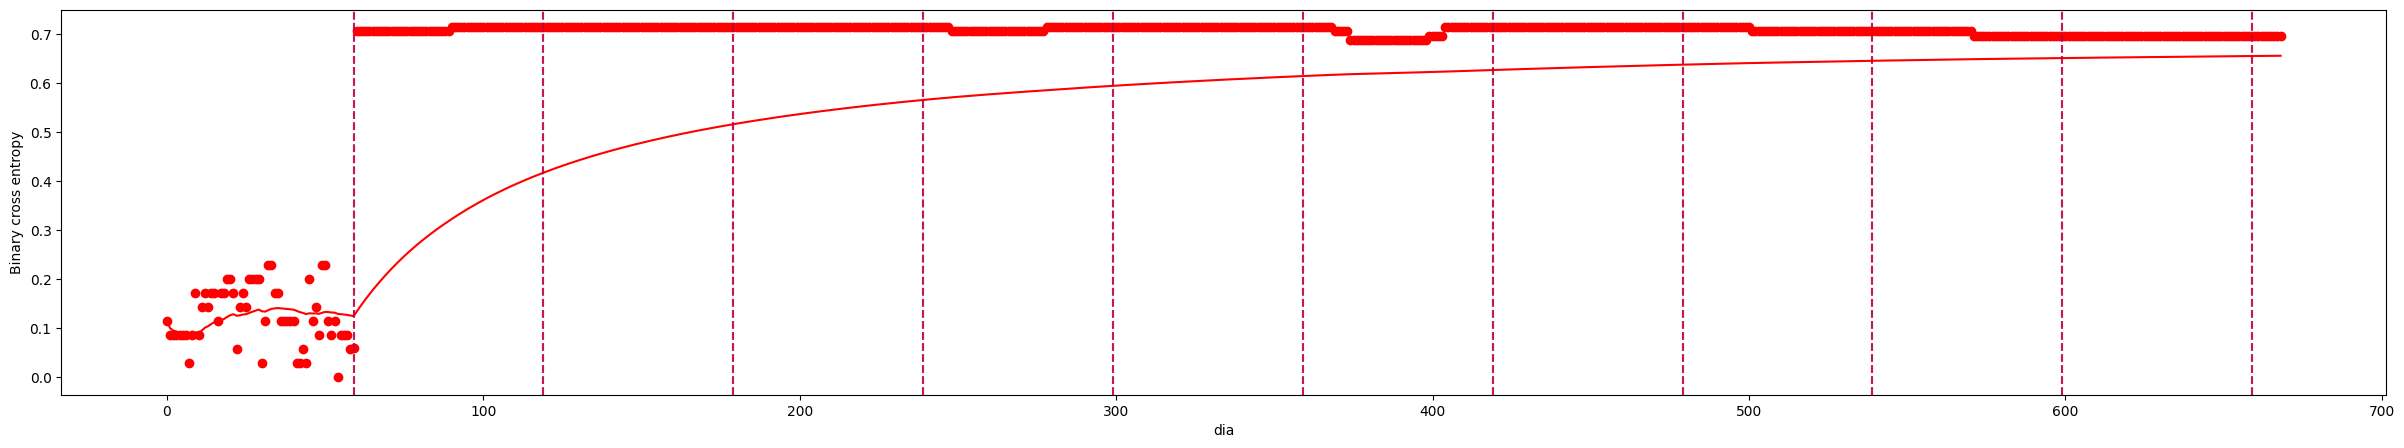

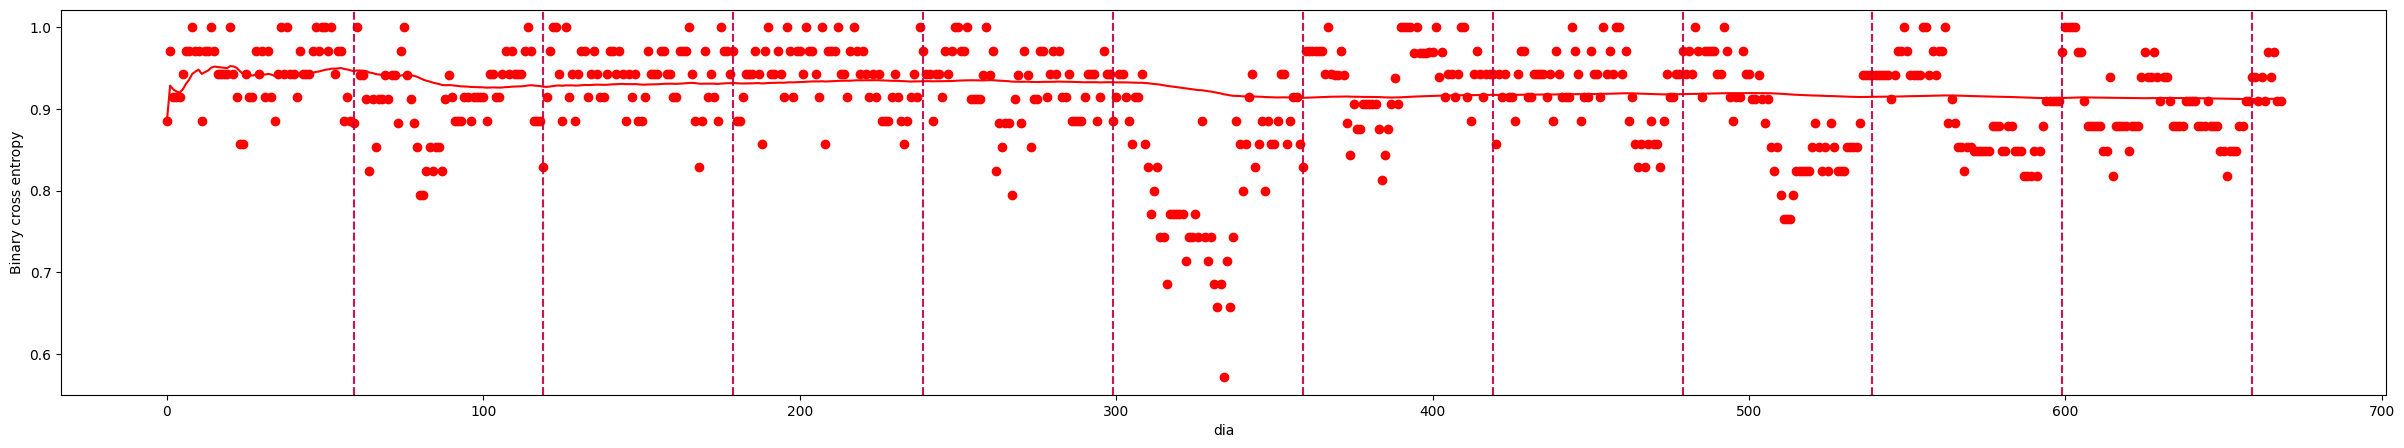

In [ ]:
ver_performance(h_accuracy_fijo)
ver_performance(h_acurracy_evolutivo )
ver_performance(h_accuracy_fijo_datos_reales )

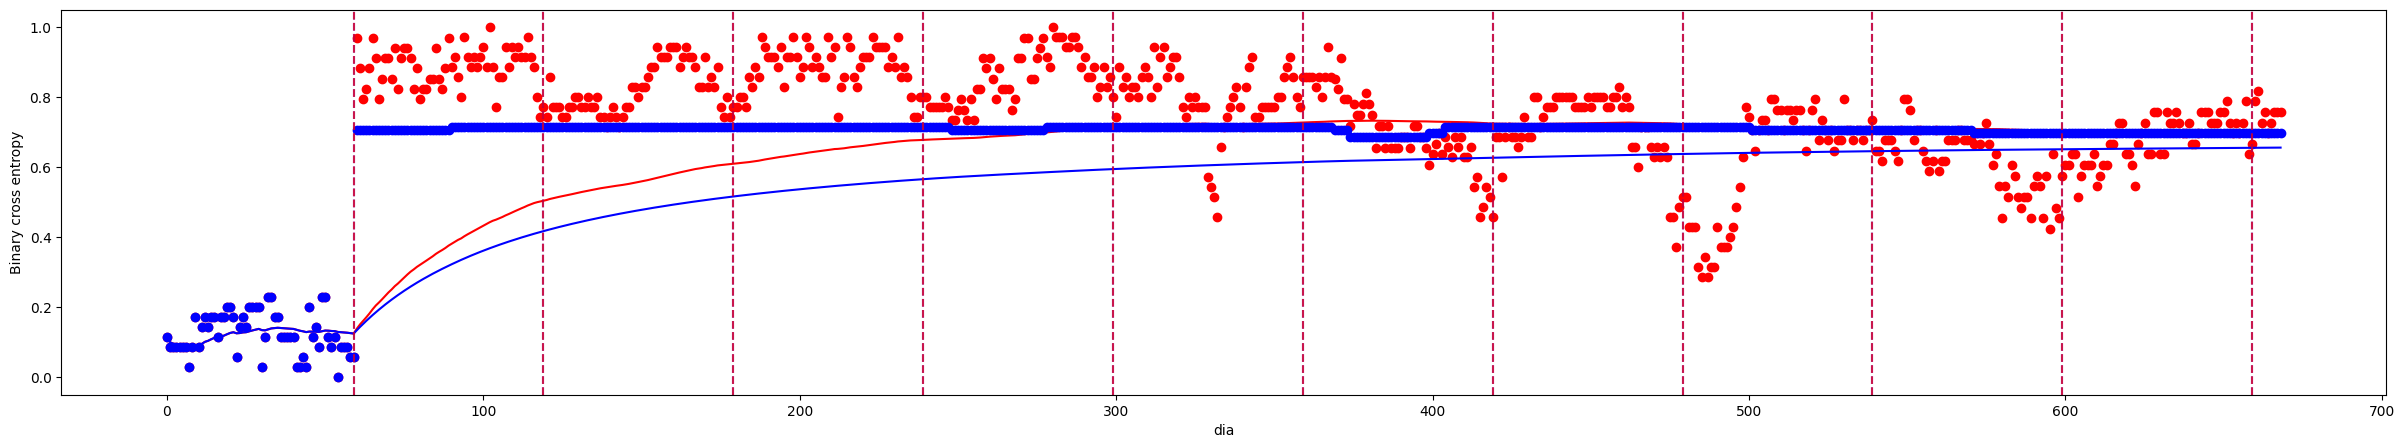

In [ ]:
# Tu array de valores
data = np.array(h_accuracy_fijo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)

fig, ax = plt.subplots(figsize=(30,5))

plt.plot( h_accuracy_fijo,  color='red',  label='h_acurracyo', marker='o', linestyle='none')

plt.plot( cumulative_average ,  color='red')


# Tu array de valores
data = np.array(h_acurracy_evolutivo)
# Calcula la suma acumulativa
cumulative_sum = np.cumsum(data)
# Calcula la media acumulativa
cumulative_average = cumulative_sum / (np.arange(len(data)) + 1)



plt.plot( h_acurracy_evolutivo,  color='blue',  label='h_acurracyo', marker='o', linestyle='none')

plt.plot( cumulative_average ,  color='blue')




# Trazar líneas verticales azules donde h_dia_entrenado sea 1
for i, value in enumerate(h_dia_entrenado):
    if value == 1:
        ax.axvline(x=i, color='blue', linestyle='--', alpha=0.7)
# Trazar líneas verticales azules donde h_dia_evolucion sea 1
for i, value in enumerate(h_dia_evolucion):
    if value == 1:
        ax.axvline(x=i, color='red', linestyle='--', alpha=0.7)


ax.set_xlabel("dia")
ax.set_ylabel("Binary cross entropy")

plt.show()

Despues de probar la 4 no parece, empeorar demasiado, al tener tener features aleatorias parece ser capaz de extraer informacion, añadiendo ese conocimiento al que adquirio al entrenarse con datos anteriores.

Es mas, funciono mejor con los datos manipulados. Esa mascara funciona como un dropout, es posible que la red aprendiera a generalizar mejor.